<a href="https://colab.research.google.com/github/Rahad31/Kl-FedDis-Research-/blob/main/uniform_truncated.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
from scipy.stats import truncnorm
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import DataLoader
from torchvision.datasets import CIFAR10
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Define VAE model
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 2*z_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.z_dim], h[:, self.z_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Define VAE training procedure
def vae_train(vae: VAE, trainloader: DataLoader, epochs: int) -> None:
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    for epoch in range(epochs):
        vae.train()
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            optimizer.zero_grad()
            recon_x, mu, logvar = vae(inputs)
            loss = vae_loss(recon_x, inputs, mu, logvar)
            loss.backward()
            optimizer.step()

        scheduler.step()


# Define classification model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create training and validation loaders
trainloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)



# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define training procedure for classification model
def train(net: nn.Module, trainloader: DataLoader, valloader: DataLoader, epochs: int) -> None:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = 0.0

    for epoch in range(epochs):
        # Training loop
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Validation loop
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(net.state_dict(), 'best_model.pth')

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / (i+1):.3f}, Validation Accuracy: {val_acc:.2f}%")

# Define evaluation procedure
def evaluate(net: nn.Module, testloader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate TP, FP, TN, FN for each class
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(all_labels, all_predictions, average=None)
    recall = recall_score(all_labels, all_predictions, average=None)
    f1 = f1_score(all_labels, all_predictions, average=None)

    return accuracy, tp, fp, tn, fn, precision, recall, f1

# Initialize clients
def initialize_clients(trainset, transform, batch_size, num_clients):
    clients = {}
    for i in range(num_clients):
        client_trainset = torch.utils.data.Subset(trainset, range(i * len(trainset) // num_clients, (i + 1) * len(trainset) // num_clients))
        client_trainloader = torch.utils.data.DataLoader(client_trainset, batch_size=batch_size, shuffle=True)
        clients[f"client_{i}"] = client_trainloader
    return clients

def get_distribution_info(vae: VAE) -> Dict:
    # Implement the logic to extract distribution information from the VAE
    # This can involve computing statistics, parameters, or any other relevant information
    # that can be used to generate augmented data

    # Example implementation:
    distribution_info = {
        "uniform": {
            "mean": vae.encoder[-1].bias.data.cpu().numpy(),
            "std": torch.exp(0.5 * vae.encoder[-1].weight.data).cpu().numpy()
        },
        "truncated": {
            "mean": vae.encoder[-1].bias.data.cpu().numpy(),
            "std": torch.exp(0.5 * vae.encoder[-1].weight.data).cpu().numpy()
        }
    }

    return distribution_info

def send_distribution_info(distribution_info: Dict) -> None:
    # Implement the logic to send the distribution information to the global server
    # This can involve using a network protocol, a message queue, or any other communication mechanism
    # to send the information

    # Example implementation:
    # Send the distribution information to the global server using a network protocol
    # For example, you can use the `socket` module to send the information over a network
    # or use a message queue like `RabbitMQ` to send the information
    pass

def generate_augmented_data(vae: VAE, distribution_info_uniform: Dict, distribution_info_truncated: Dict) -> torch.Tensor:
    # Generate augmented data using both uniform and truncated uniform distributions

    mean = distribution_info_uniform["mean"].mean().item()  # Convert numpy array to float
    std = distribution_info_uniform["std"].mean().item()  # Convert numpy array to float



     # Generate augmented data using Uniform distribution
    augmented_data_uniform1 = torch.FloatTensor(64, vae.z_dim).uniform_(mean - std, mean + std)

    mean2 = distribution_info_uniform["mean"].mean().item()  # Convert numpy array to float
    std2 = distribution_info_uniform["std"].mean().item()  # Convert numpy array to float



     # Generate augmented data using Uniform distribution
    augmented_data_uniform2 = torch.FloatTensor(64, vae.z_dim).uniform_(mean2 - std2, mean2 + std2)


    # Calculate the average of augmented data from both distributions
    augmented_data_average = (augmented_data_uniform1 + augmented_data_uniform2) / 2

    return augmented_data_average

def federated_train(net: nn.Module, vae: VAE, trainloaders: Dict[str, DataLoader], trainloader: DataLoader, valloader: DataLoader, epochs: int) -> None:
    for epoch in range(epochs):
        for client_id, client_trainloader in trainloaders.items():
            # Train VAE on client data
            vae_train(vae, client_trainloader, epochs=10)

            # Share distribution information with global server
            distribution_info = get_distribution_info(vae)
            send_distribution_info(distribution_info)

            # Receive distribution information from other clients
            other_distribution_info = receive_distribution_info()

            # Generate augmented data using received distribution information
            augmented_data = generate_augmented_data(vae, other_distribution_info["uniform"], other_distribution_info["uniform"])

            # Train classification model using local, augmented, and validation data
            train(net, client_trainloader, valloader, epochs=10)

            # Send model updates to global server
            send_model_update(client_id, net.state_dict())

# Define logic to receive distribution information from global server
def receive_distribution_info() -> Dict:
    # Receive distribution information logic
    distribution_info = {
        "uniform": {
            "mean": np.zeros(20),  # Adjust the size based on your latent space dimension
            "std": np.ones(20)
        },
        "uniform": {
            "mean": np.zeros(20),
            "std": np.ones(20)
        }
    }
    return distribution_info

def send_model_update(client_id: str, model_update: Dict) -> None:
    # Implement the logic to send the model update to the global server
    # This can involve using a network protocol, a message queue, or any other communication mechanism
    # to send the model update

    # Example implementation:
    # Send the model update to the global server using a network protocol
    # For example, you can use the `socket` module to send the information over a network
    # or use a message queue like `RabbitMQ` to send the information
    pass

# Define global server procedure
def global_server() -> None:
    net = Net()
    x_dim = 3 * 32 * 32  # CIFAR-10 input size
    h_dim = 400
    z_dim = 20
    vae = VAE(x_dim, h_dim, z_dim)  # Initialize VAE object with required arguments

    # Initialize clients
    num_clients = 5  # Define the number of clients
    clients = initialize_clients(train_set, transform, batch_size=128, num_clients=num_clients)

    # Train model using FedDIS
    federated_train(net, vae, clients, trainloader, valloader, epochs=10)

    # Evaluate final model
    test_accuracy, tp, fp, tn, fn, precision, recall, f1 = evaluate(net, testloader)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print(":", fn+tn+tp+fp)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

if __name__ == "__main__":
    global_server()


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/10], Training Loss: 2.306, Validation Accuracy: 10.49%
Epoch [2/10], Training Loss: 2.305, Validation Accuracy: 10.52%
Epoch [3/10], Training Loss: 2.304, Validation Accuracy: 10.44%
Epoch [4/10], Training Loss: 2.303, Validation Accuracy: 10.51%
Epoch [5/10], Training Loss: 2.303, Validation Accuracy: 10.61%
Epoch [6/10], Training Loss: 2.302, Validation Accuracy: 10.67%
Epoch [7/10], Training Loss: 2.302, Validation Accuracy: 10.97%
Epoch [8/10], Training Loss: 2.301, Validation Accuracy: 11.34%
Epoch [9/10], Training Loss: 2.301, Validation Accuracy: 11.72%
Epoch [10/10], Training Loss: 2.300, Validation Accuracy: 12.03%
Epoch [1/10], Training Loss: 2.299, Validation Accuracy: 11.57%
Epoch [2/10], Training Loss: 2.298, Validation Accuracy: 12.37%
Epoch [3/10], Training Loss: 2.296, Validation Accuracy: 12.71%
Epoch [4/10], Training Loss: 2.294, Validation Accuracy: 13.19%
Epoch [5/10], Training Loss

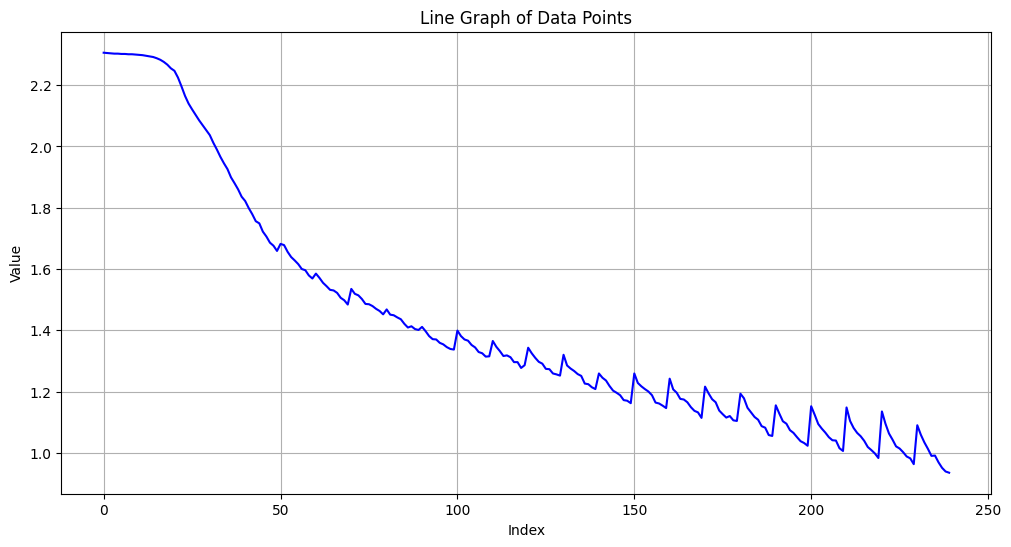

In [ ]:
import matplotlib.pyplot as plt

# Your data
data = [
    2.306, 2.305, 2.304, 2.303, 2.303, 2.302, 2.302, 2.301, 2.301, 2.300,
    2.299, 2.298, 2.296, 2.294, 2.292, 2.288, 2.283, 2.276, 2.267, 2.255,
    2.247, 2.225, 2.196, 2.165, 2.140, 2.121, 2.103, 2.085, 2.069, 2.053,
    2.037, 2.012, 1.990, 1.966, 1.945, 1.926, 1.899, 1.880, 1.860, 1.836,
    1.822, 1.799, 1.779, 1.756, 1.749, 1.722, 1.706, 1.686, 1.676, 1.659,
    1.682, 1.678, 1.656, 1.639, 1.628, 1.616, 1.600, 1.596, 1.579, 1.569,
    1.585, 1.571, 1.555, 1.544, 1.532, 1.530, 1.522, 1.506, 1.498, 1.484,
    1.535, 1.519, 1.514, 1.502, 1.486, 1.485, 1.479, 1.470, 1.463, 1.452,
    1.468, 1.451, 1.449, 1.442, 1.436, 1.421, 1.409, 1.413, 1.404, 1.401,
    1.411, 1.397, 1.381, 1.371, 1.370, 1.359, 1.354, 1.345, 1.339, 1.337,
    1.399, 1.381, 1.370, 1.366, 1.352, 1.344, 1.329, 1.325, 1.314, 1.315,
    1.365, 1.346, 1.332, 1.316, 1.318, 1.312, 1.296, 1.296, 1.277, 1.286,
    1.343, 1.325, 1.310, 1.297, 1.291, 1.274, 1.273, 1.259, 1.256, 1.252,
    1.320, 1.285, 1.275, 1.267, 1.257, 1.251, 1.226, 1.224, 1.214, 1.208,
    1.259, 1.245, 1.236, 1.218, 1.203, 1.196, 1.188, 1.172, 1.170, 1.162,
    1.259, 1.228, 1.217, 1.208, 1.200, 1.188, 1.164, 1.161, 1.154, 1.146,
    1.242, 1.207, 1.196, 1.176, 1.174, 1.165, 1.149, 1.137, 1.132, 1.114,
    1.216, 1.194, 1.175, 1.165, 1.138, 1.126, 1.115, 1.120, 1.106, 1.104,
    1.193, 1.178, 1.147, 1.132, 1.117, 1.108, 1.087, 1.082, 1.058, 1.055,
    1.155, 1.128, 1.103, 1.095, 1.074, 1.065, 1.051, 1.038, 1.032, 1.023,
    1.152, 1.124, 1.094, 1.079, 1.066, 1.051, 1.041, 1.040, 1.015, 1.006,
    1.148, 1.104, 1.081, 1.065, 1.054, 1.039, 1.019, 1.009, 0.998, 0.983,
    1.135, 1.095, 1.063, 1.043, 1.021, 1.014, 1.002, 0.988, 0.982, 0.963,
    1.090, 1.059, 1.034, 1.013, 0.990, 0.991, 0.969, 0.951, 0.939, 0.935
]

# Create a figure and axis
plt.figure(figsize=(12, 6))

# Plot the data
plt.plot(data, marker='', linestyle='-', color='b')

# Add title and labels
plt.title('Line Graph of Data Points')
plt.xlabel('Index')
plt.ylabel('Value')

# Display the grid
plt.grid(True)

# Show the plot
plt.show()


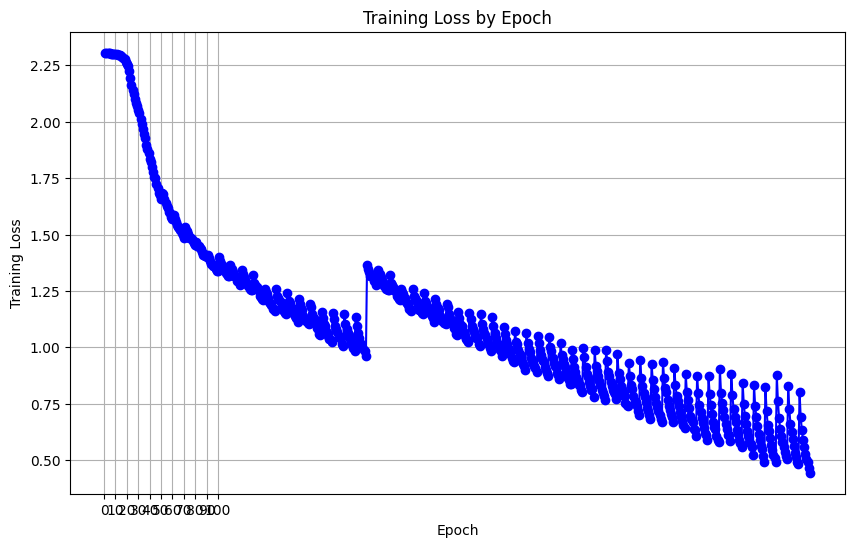

In [ ]:
import matplotlib.pyplot as plt

# Extracting training loss values
loss_values = [
    2.306, 2.305, 2.304, 2.303, 2.303, 2.302, 2.302, 2.301, 2.301, 2.300,
 2.299, 2.298, 2.296, 2.294, 2.292, 2.288, 2.283, 2.276, 2.267, 2.255,
 2.247, 2.225, 2.196, 2.165, 2.140, 2.121, 2.103, 2.085, 2.069, 2.053,
 2.037, 2.012, 1.990, 1.966, 1.945, 1.926, 1.899, 1.880, 1.860, 1.836,
 1.822, 1.799, 1.779, 1.756, 1.749, 1.722, 1.706, 1.686, 1.676, 1.659,
 1.682, 1.678, 1.656, 1.639, 1.628, 1.616, 1.600, 1.596, 1.579, 1.569,
 1.585, 1.571, 1.555, 1.544, 1.532, 1.530, 1.522, 1.506, 1.498, 1.484,
 1.535, 1.519, 1.514, 1.502, 1.486, 1.485, 1.479, 1.470, 1.463, 1.452,
 1.468, 1.451, 1.449, 1.442, 1.436, 1.421, 1.409, 1.413, 1.404, 1.401,
 1.411, 1.397, 1.381, 1.371, 1.370, 1.359, 1.354, 1.345, 1.339, 1.337,
 1.399, 1.381, 1.370, 1.366, 1.352, 1.344, 1.329, 1.325, 1.314, 1.315,
    1.365, 1.346, 1.332, 1.316, 1.318, 1.312, 1.296, 1.296, 1.277, 1.286,
    1.343, 1.325, 1.310, 1.297, 1.291, 1.274, 1.273, 1.259, 1.256, 1.252,
    1.320, 1.285, 1.275, 1.267, 1.257, 1.251, 1.226, 1.224, 1.214, 1.208,
    1.259, 1.245, 1.236, 1.218, 1.203, 1.196, 1.188, 1.172, 1.170, 1.162,
    1.259, 1.228, 1.217, 1.208, 1.200, 1.188, 1.164, 1.161, 1.154, 1.146,
    1.242, 1.207, 1.196, 1.176, 1.174, 1.165, 1.149, 1.137, 1.132, 1.114,
    1.216, 1.194, 1.175, 1.165, 1.138, 1.126, 1.115, 1.120, 1.106, 1.104,
    1.193, 1.178, 1.147, 1.132, 1.117, 1.108, 1.087, 1.082, 1.058, 1.055,
    1.155, 1.128, 1.103, 1.095, 1.074, 1.065, 1.051, 1.038, 1.032, 1.023,
    1.152, 1.124, 1.094, 1.079, 1.066, 1.051, 1.041, 1.040, 1.015, 1.006,
    1.148, 1.104, 1.081, 1.065, 1.054, 1.039, 1.019, 1.009, 0.998, 0.983,
    1.135, 1.095, 1.063, 1.043, 1.021, 1.014, 1.002, 0.988, 0.982, 0.963,


 1.365, 1.346, 1.332, 1.316, 1.318, 1.312, 1.296, 1.296, 1.277, 1.286,
    1.343, 1.325, 1.310, 1.297, 1.291, 1.274, 1.273, 1.259, 1.256, 1.252,
    1.320, 1.285, 1.275, 1.267, 1.257, 1.251, 1.226, 1.224, 1.214, 1.208,
    1.259, 1.245, 1.236, 1.218, 1.203, 1.196, 1.188, 1.172, 1.170, 1.162,
    1.259, 1.228, 1.217, 1.208, 1.200, 1.188, 1.164, 1.161, 1.154, 1.146,
    1.242, 1.207, 1.196, 1.176, 1.174, 1.165, 1.149, 1.137, 1.132, 1.114,
    1.216, 1.194, 1.175, 1.165, 1.138, 1.126, 1.115, 1.120, 1.106, 1.104,
    1.193, 1.178, 1.147, 1.132, 1.117, 1.108, 1.087, 1.082, 1.058, 1.055,
    1.155, 1.128, 1.103, 1.095, 1.074, 1.065, 1.051, 1.038, 1.032, 1.023,
    1.152, 1.124, 1.094, 1.079, 1.066, 1.051, 1.041, 1.040, 1.015, 1.006,
    1.148, 1.104, 1.081, 1.065, 1.054, 1.039, 1.019, 1.009, 0.998, 0.983,
    1.135, 1.095, 1.063, 1.043, 1.021, 1.014, 1.002, 0.988, 0.982, 0.963,
    1.090, 1.059, 1.034, 1.013, 0.990, 0.991, 0.969, 0.951, 0.939, 0.935,
    1.074, 1.022, 1.014, 0.986, 0.971, 0.958, 0.935, 0.925, 0.917, 0.899,


     1.064, 1.017, 0.994, 0.981, 0.952, 0.939, 0.928, 0.919, 0.910, 0.889,
    1.052, 1.021, 0.987, 0.964, 0.946, 0.939, 0.913, 0.899, 0.888, 0.873,
    1.047, 1.003, 0.983, 0.954, 0.930, 0.917, 0.913, 0.888, 0.876, 0.859,
    1.017, 0.967, 0.948, 0.925, 0.912, 0.889, 0.869, 0.855, 0.838, 0.836,
    0.989, 0.948, 0.914, 0.889, 0.868, 0.852, 0.835, 0.831, 0.809, 0.801,
    0.997, 0.955, 0.914, 0.883, 0.868, 0.846, 0.829, 0.810, 0.815, 0.781,
    0.986, 0.918, 0.897, 0.871, 0.850, 0.834, 0.812, 0.799, 0.782, 0.766,
    0.990, 0.938, 0.890, 0.871, 0.846, 0.830, 0.809, 0.801, 0.791, 0.770,
    0.970, 0.886, 0.859, 0.830, 0.817, 0.800, 0.784, 0.755, 0.745, 0.741,
    0.930, 0.873, 0.834, 0.816, 0.784, 0.761, 0.759, 0.739, 0.717, 0.702,
    0.944, 0.863, 0.828, 0.797, 0.779, 0.758, 0.732, 0.719, 0.698, 0.680,
    0.924, 0.857, 0.813, 0.780, 0.752, 0.736, 0.716, 0.702, 0.682, 0.669,
    0.935, 0.862, 0.819, 0.800, 0.766, 0.739, 0.720, 0.705, 0.692, 0.669,
    0.908, 0.832, 0.786, 0.762, 0.739, 0.714, 0.691, 0.672, 0.654, 0.643,
    0.880, 0.800, 0.766, 0.731, 0.696, 0.681, 0.668, 0.639, 0.634, 0.608,
    0.875, 0.796, 0.744, 0.713, 0.686, 0.666, 0.641, 0.618, 0.610, 0.591,
    0.872, 0.793, 0.743, 0.704, 0.671, 0.647, 0.640, 0.606, 0.590, 0.579,
    0.905, 0.799, 0.755, 0.720, 0.692, 0.661, 0.640, 0.612, 0.611, 0.585,
    0.880, 0.789, 0.727, 0.689, 0.668, 0.633, 0.617, 0.589, 0.575, 0.560,
    0.842, 0.749, 0.696, 0.658, 0.628, 0.605, 0.580, 0.572, 0.557, 0.523,
    0.835, 0.738, 0.691, 0.649, 0.614, 0.589, 0.564, 0.551, 0.520, 0.493,
    0.826, 0.718, 0.657, 0.628, 0.599, 0.566, 0.546, 0.521, 0.508, 0.490,
    0.876, 0.761, 0.685, 0.636, 0.608, 0.582, 0.560, 0.536, 0.517, 0.503,
    0.830, 0.727, 0.660, 0.625, 0.592, 0.564, 0.533, 0.515, 0.493, 0.482,
    0.804, 0.690, 0.635, 0.590, 0.556, 0.525, 0.503, 0.492, 0.464, 0.444

]

# Epochs (assuming 100 epochs based on the number of values)
epochs = list(range(1, len(loss_values) + 1))

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(epochs, loss_values, marker='o', linestyle='-', color='b')
plt.title('Training Loss by Epoch')
plt.xlabel('Epoch')
plt.ylabel('Training Loss')
plt.grid(True)
plt.xticks(range(0, 101, 10))  # Set x-ticks to every 10 epochs
plt.show()



In [ ]:
import re

# Your provided text
log = """
Epoch [1/10], Training Loss: 2.306, Validation Accuracy: 10.49%
Epoch [2/10], Training Loss: 2.305, Validation Accuracy: 10.52%
Epoch [3/10], Training Loss: 2.304, Validation Accuracy: 10.44%
Epoch [4/10], Training Loss: 2.303, Validation Accuracy: 10.51%
Epoch [5/10], Training Loss: 2.303, Validation Accuracy: 10.61%
Epoch [6/10], Training Loss: 2.302, Validation Accuracy: 10.67%
Epoch [7/10], Training Loss: 2.302, Validation Accuracy: 10.97%
Epoch [8/10], Training Loss: 2.301, Validation Accuracy: 11.34%
Epoch [9/10], Training Loss: 2.301, Validation Accuracy: 11.72%
Epoch [10/10], Training Loss: 2.300, Validation Accuracy: 12.03%
Epoch [1/10], Training Loss: 2.299, Validation Accuracy: 11.57%
Epoch [2/10], Training Loss: 2.298, Validation Accuracy: 12.37%
Epoch [3/10], Training Loss: 2.296, Validation Accuracy: 12.71%
Epoch [4/10], Training Loss: 2.294, Validation Accuracy: 13.19%
Epoch [5/10], Training Loss: 2.292, Validation Accuracy: 12.54%
Epoch [6/10], Training Loss: 2.288, Validation Accuracy: 12.56%
Epoch [7/10], Training Loss: 2.283, Validation Accuracy: 12.75%
Epoch [8/10], Training Loss: 2.276, Validation Accuracy: 14.95%
Epoch [9/10], Training Loss: 2.267, Validation Accuracy: 16.23%
Epoch [10/10], Training Loss: 2.255, Validation Accuracy: 16.99%
Epoch [1/10], Training Loss: 2.247, Validation Accuracy: 17.97%
Epoch [2/10], Training Loss: 2.225, Validation Accuracy: 19.50%
Epoch [3/10], Training Loss: 2.196, Validation Accuracy: 20.81%
Epoch [4/10], Training Loss: 2.165, Validation Accuracy: 22.00%
Epoch [5/10], Training Loss: 2.140, Validation Accuracy: 23.25%
Epoch [6/10], Training Loss: 2.121, Validation Accuracy: 24.05%
Epoch [7/10], Training Loss: 2.103, Validation Accuracy: 24.85%
Epoch [8/10], Training Loss: 2.085, Validation Accuracy: 26.23%
Epoch [9/10], Training Loss: 2.069, Validation Accuracy: 26.35%
Epoch [10/10], Training Loss: 2.053, Validation Accuracy: 27.20%
Epoch [1/10], Training Loss: 2.037, Validation Accuracy: 27.86%
Epoch [2/10], Training Loss: 2.012, Validation Accuracy: 28.99%
Epoch [3/10], Training Loss: 1.990, Validation Accuracy: 29.53%
Epoch [4/10], Training Loss: 1.966, Validation Accuracy: 30.15%
Epoch [5/10], Training Loss: 1.945, Validation Accuracy: 30.40%
Epoch [6/10], Training Loss: 1.926, Validation Accuracy: 30.96%
Epoch [7/10], Training Loss: 1.899, Validation Accuracy: 31.20%
Epoch [8/10], Training Loss: 1.880, Validation Accuracy: 31.91%
Epoch [9/10], Training Loss: 1.860, Validation Accuracy: 33.12%
Epoch [10/10], Training Loss: 1.836, Validation Accuracy: 32.13%
Epoch [1/10], Training Loss: 1.822, Validation Accuracy: 33.98%
Epoch [2/10], Training Loss: 1.799, Validation Accuracy: 34.74%
Epoch [3/10], Training Loss: 1.779, Validation Accuracy: 35.68%
Epoch [4/10], Training Loss: 1.756, Validation Accuracy: 35.30%
Epoch [5/10], Training Loss: 1.749, Validation Accuracy: 36.68%
Epoch [6/10], Training Loss: 1.722, Validation Accuracy: 37.59%
Epoch [7/10], Training Loss: 1.706, Validation Accuracy: 36.94%
Epoch [8/10], Training Loss: 1.686, Validation Accuracy: 37.78%
Epoch [9/10], Training Loss: 1.676, Validation Accuracy: 37.58%
Epoch [10/10], Training Loss: 1.659, Validation Accuracy: 38.83%
Epoch [1/10], Training Loss: 1.682, Validation Accuracy: 38.68%
Epoch [2/10], Training Loss: 1.678, Validation Accuracy: 38.65%
Epoch [3/10], Training Loss: 1.656, Validation Accuracy: 39.73%
Epoch [4/10], Training Loss: 1.639, Validation Accuracy: 39.57%
Epoch [5/10], Training Loss: 1.628, Validation Accuracy: 40.25%
Epoch [6/10], Training Loss: 1.616, Validation Accuracy: 39.94%
Epoch [7/10], Training Loss: 1.600, Validation Accuracy: 40.80%
Epoch [8/10], Training Loss: 1.596, Validation Accuracy: 40.33%
Epoch [9/10], Training Loss: 1.579, Validation Accuracy: 40.61%
Epoch [10/10], Training Loss: 1.569, Validation Accuracy: 41.58%
Epoch [1/10], Training Loss: 1.585, Validation Accuracy: 42.38%
Epoch [2/10], Training Loss: 1.571, Validation Accuracy: 42.63%
Epoch [3/10], Training Loss: 1.555, Validation Accuracy: 42.52%
Epoch [4/10], Training Loss: 1.544, Validation Accuracy: 43.12%
Epoch [5/10], Training Loss: 1.532, Validation Accuracy: 42.77%
Epoch [6/10], Training Loss: 1.530, Validation Accuracy: 43.20%
Epoch [7/10], Training Loss: 1.522, Validation Accuracy: 43.12%
Epoch [8/10], Training Loss: 1.506, Validation Accuracy: 44.00%
Epoch [9/10], Training Loss: 1.498, Validation Accuracy: 44.28%
Epoch [10/10], Training Loss: 1.484, Validation Accuracy: 44.14%
Epoch [1/10], Training Loss: 1.535, Validation Accuracy: 44.21%
Epoch [2/10], Training Loss: 1.519, Validation Accuracy: 45.17%
Epoch [3/10], Training Loss: 1.514, Validation Accuracy: 44.41%
Epoch [4/10], Training Loss: 1.502, Validation Accuracy: 45.62%
Epoch [5/10], Training Loss: 1.486, Validation Accuracy: 44.69%
Epoch [6/10], Training Loss: 1.485, Validation Accuracy: 45.73%
Epoch [7/10], Training Loss: 1.479, Validation Accuracy: 45.51%
Epoch [8/10], Training Loss: 1.470, Validation Accuracy: 46.17%
Epoch [9/10], Training Loss: 1.463, Validation Accuracy: 46.50%
Epoch [10/10], Training Loss: 1.452, Validation Accuracy: 47.02%
Epoch [1/10], Training Loss: 1.468, Validation Accuracy: 46.63%
Epoch [2/10], Training Loss: 1.451, Validation Accuracy: 47.07%
Epoch [3/10], Training Loss: 1.449, Validation Accuracy: 45.33%
Epoch [4/10], Training Loss: 1.442, Validation Accuracy: 46.67%
Epoch [5/10], Training Loss: 1.436, Validation Accuracy: 47.09%
Epoch [6/10], Training Loss: 1.421, Validation Accuracy: 46.71%
Epoch [7/10], Training Loss: 1.409, Validation Accuracy: 46.51%
Epoch [8/10], Training Loss: 1.413, Validation Accuracy: 47.63%
Epoch [9/10], Training Loss: 1.404, Validation Accuracy: 47.40%
Epoch [10/10], Training Loss: 1.401, Validation Accuracy: 48.20%
Epoch [1/10], Training Loss: 1.411, Validation Accuracy: 48.03%
Epoch [2/10], Training Loss: 1.397, Validation Accuracy: 48.47%
Epoch [3/10], Training Loss: 1.381, Validation Accuracy: 47.91%
Epoch [4/10], Training Loss: 1.371, Validation Accuracy: 48.12%
Epoch [5/10], Training Loss: 1.370, Validation Accuracy: 47.96%
Epoch [6/10], Training Loss: 1.359, Validation Accuracy: 47.87%
Epoch [7/10], Training Loss: 1.354, Validation Accuracy: 47.74%
Epoch [8/10], Training Loss: 1.345, Validation Accuracy: 47.72%
Epoch [9/10], Training Loss: 1.339, Validation Accuracy: 46.46%
Epoch [10/10], Training Loss: 1.337, Validation Accuracy: 48.78%
Epoch [1/10], Training Loss: 1.399, Validation Accuracy: 48.96%
Epoch [2/10], Training Loss: 1.381, Validation Accuracy: 48.91%
Epoch [3/10], Training Loss: 1.370, Validation Accuracy: 48.90%
Epoch [4/10], Training Loss: 1.366, Validation Accuracy: 48.57%
Epoch [5/10], Training Loss: 1.352, Validation Accuracy: 49.47%
Epoch [6/10], Training Loss: 1.344, Validation Accuracy: 49.99%
Epoch [7/10], Training Loss: 1.329, Validation Accuracy: 50.10%
Epoch [8/10], Training Loss: 1.325, Validation Accuracy: 49.88%
Epoch [9/10], Training Loss: 1.314, Validation Accuracy: 49.33%
Epoch [10/10], Training Loss: 1.315, Validation Accuracy: 49.96%
Epoch [1/10], Training Loss: 1.365, Validation Accuracy: 50.60%
Epoch [2/10], Training Loss: 1.346, Validation Accuracy: 51.01%
Epoch [3/10], Training Loss: 1.332, Validation Accuracy: 51.06%
Epoch [4/10], Training Loss: 1.316, Validation Accuracy: 50.49%
Epoch [5/10], Training Loss: 1.318, Validation Accuracy: 50.70%
Epoch [6/10], Training Loss: 1.312, Validation Accuracy: 51.46%
Epoch [7/10], Training Loss: 1.296, Validation Accuracy: 50.65%
Epoch [8/10], Training Loss: 1.296, Validation Accuracy: 50.12%
Epoch [9/10], Training Loss: 1.277, Validation Accuracy: 51.25%
Epoch [10/10], Training Loss: 1.286, Validation Accuracy: 50.83%
Epoch [1/10], Training Loss: 1.343, Validation Accuracy: 50.40%
Epoch [2/10], Training Loss: 1.325, Validation Accuracy: 51.50%
Epoch [3/10], Training Loss: 1.310, Validation Accuracy: 49.52%
Epoch [4/10], Training Loss: 1.297, Validation Accuracy: 48.86%
Epoch [5/10], Training Loss: 1.291, Validation Accuracy: 51.82%
Epoch [6/10], Training Loss: 1.274, Validation Accuracy: 51.79%
Epoch [7/10], Training Loss: 1.273, Validation Accuracy: 52.08%
Epoch [8/10], Training Loss: 1.259, Validation Accuracy: 51.80%
Epoch [9/10], Training Loss: 1.256, Validation Accuracy: 51.76%
Epoch [10/10], Training Loss: 1.252, Validation Accuracy: 52.18%
Epoch [1/10], Training Loss: 1.320, Validation Accuracy: 52.28%
Epoch [2/10], Training Loss: 1.285, Validation Accuracy: 52.01%
Epoch [3/10], Training Loss: 1.275, Validation Accuracy: 51.91%
Epoch [4/10], Training Loss: 1.267, Validation Accuracy: 49.96%
Epoch [5/10], Training Loss: 1.257, Validation Accuracy: 52.47%
Epoch [6/10], Training Loss: 1.251, Validation Accuracy: 52.60%
Epoch [7/10], Training Loss: 1.226, Validation Accuracy: 52.56%
Epoch [8/10], Training Loss: 1.224, Validation Accuracy: 52.46%
Epoch [9/10], Training Loss: 1.214, Validation Accuracy: 52.67%
Epoch [10/10], Training Loss: 1.208, Validation Accuracy: 52.96%
Epoch [1/10], Training Loss: 1.259, Validation Accuracy: 52.77%
Epoch [2/10], Training Loss: 1.245, Validation Accuracy: 52.32%
Epoch [3/10], Training Loss: 1.236, Validation Accuracy: 52.67%
Epoch [4/10], Training Loss: 1.218, Validation Accuracy: 51.33%
Epoch [5/10], Training Loss: 1.203, Validation Accuracy: 51.99%
Epoch [6/10], Training Loss: 1.196, Validation Accuracy: 52.84%
Epoch [7/10], Training Loss: 1.188, Validation Accuracy: 53.13%
Epoch [8/10], Training Loss: 1.172, Validation Accuracy: 53.78%
Epoch [9/10], Training Loss: 1.170, Validation Accuracy: 53.08%
Epoch [10/10], Training Loss: 1.162, Validation Accuracy: 53.75%
Epoch [1/10], Training Loss: 1.259, Validation Accuracy: 54.47%
Epoch [2/10], Training Loss: 1.228, Validation Accuracy: 54.18%
Epoch [3/10], Training Loss: 1.217, Validation Accuracy: 54.16%
Epoch [4/10], Training Loss: 1.208, Validation Accuracy: 53.96%
Epoch [5/10], Training Loss: 1.200, Validation Accuracy: 54.41%
Epoch [6/10], Training Loss: 1.188, Validation Accuracy: 54.32%
Epoch [7/10], Training Loss: 1.164, Validation Accuracy: 54.21%
Epoch [8/10], Training Loss: 1.161, Validation Accuracy: 53.22%
Epoch [9/10], Training Loss: 1.154, Validation Accuracy: 54.33%
Epoch [10/10], Training Loss: 1.146, Validation Accuracy: 54.57%
Epoch [1/10], Training Loss: 1.242, Validation Accuracy: 54.89%
Epoch [2/10], Training Loss: 1.207, Validation Accuracy: 54.26%
Epoch [3/10], Training Loss: 1.196, Validation Accuracy: 54.76%
Epoch [4/10], Training Loss: 1.176, Validation Accuracy: 53.44%
Epoch [5/10], Training Loss: 1.174, Validation Accuracy: 55.41%
Epoch [6/10], Training Loss: 1.165, Validation Accuracy: 55.47%
Epoch [7/10], Training Loss: 1.149, Validation Accuracy: 54.07%
Epoch [8/10], Training Loss: 1.137, Validation Accuracy: 55.06%
Epoch [9/10], Training Loss: 1.132, Validation Accuracy: 55.37%
Epoch [10/10], Training Loss: 1.114, Validation Accuracy: 54.68%
Epoch [1/10], Training Loss: 1.216, Validation Accuracy: 55.13%
Epoch [2/10], Training Loss: 1.194, Validation Accuracy: 55.78%
Epoch [3/10], Training Loss: 1.175, Validation Accuracy: 54.68%
Epoch [4/10], Training Loss: 1.165, Validation Accuracy: 56.29%
Epoch [5/10], Training Loss: 1.138, Validation Accuracy: 56.06%
Epoch [6/10], Training Loss: 1.126, Validation Accuracy: 56.28%
Epoch [7/10], Training Loss: 1.115, Validation Accuracy: 55.22%
Epoch [8/10], Training Loss: 1.120, Validation Accuracy: 54.97%
Epoch [9/10], Training Loss: 1.106, Validation Accuracy: 55.87%
Epoch [10/10], Training Loss: 1.104, Validation Accuracy: 55.51%
Epoch [1/10], Training Loss: 1.193, Validation Accuracy: 55.85%
Epoch [2/10], Training Loss: 1.178, Validation Accuracy: 53.88%
Epoch [3/10], Training Loss: 1.147, Validation Accuracy: 55.91%
Epoch [4/10], Training Loss: 1.132, Validation Accuracy: 55.92%
Epoch [5/10], Training Loss: 1.117, Validation Accuracy: 55.65%
Epoch [6/10], Training Loss: 1.108, Validation Accuracy: 55.89%
Epoch [7/10], Training Loss: 1.087, Validation Accuracy: 56.14%
Epoch [8/10], Training Loss: 1.082, Validation Accuracy: 55.74%
Epoch [9/10], Training Loss: 1.058, Validation Accuracy: 56.46%
Epoch [10/10], Training Loss: 1.055, Validation Accuracy: 56.26%
Epoch [1/10], Training Loss: 1.155, Validation Accuracy: 56.98%
Epoch [2/10], Training Loss: 1.128, Validation Accuracy: 56.48%
Epoch [3/10], Training Loss: 1.103, Validation Accuracy: 55.57%
Epoch [4/10], Training Loss: 1.095, Validation Accuracy: 56.77%
Epoch [5/10], Training Loss: 1.074, Validation Accuracy: 56.64%
Epoch [6/10], Training Loss: 1.065, Validation Accuracy: 56.61%
Epoch [7/10], Training Loss: 1.051, Validation Accuracy: 55.99%
Epoch [8/10], Training Loss: 1.038, Validation Accuracy: 57.03%
Epoch [9/10], Training Loss: 1.032, Validation Accuracy: 54.79%
Epoch [10/10], Training Loss: 1.023, Validation Accuracy: 55.60%
Epoch [1/10], Training Loss: 1.152, Validation Accuracy: 56.11%
Epoch [2/10], Training Loss: 1.124, Validation Accuracy: 57.31%
Epoch [3/10], Training Loss: 1.094, Validation Accuracy: 57.43%
Epoch [4/10], Training Loss: 1.079, Validation Accuracy: 56.87%
Epoch [5/10], Training Loss: 1.066, Validation Accuracy: 56.14%
Epoch [6/10], Training Loss: 1.051, Validation Accuracy: 57.60%
Epoch [7/10], Training Loss: 1.041, Validation Accuracy: 57.12%
Epoch [8/10], Training Loss: 1.040, Validation Accuracy: 57.75%
Epoch [9/10], Training Loss: 1.015, Validation Accuracy: 57.59%
Epoch [10/10], Training Loss: 1.006, Validation Accuracy: 56.76%
Epoch [1/10], Training Loss: 1.148, Validation Accuracy: 57.59%
Epoch [2/10], Training Loss: 1.104, Validation Accuracy: 57.93%
Epoch [3/10], Training Loss: 1.081, Validation Accuracy: 57.80%
Epoch [4/10], Training Loss: 1.065, Validation Accuracy: 56.94%
Epoch [5/10], Training Loss: 1.054, Validation Accuracy: 58.21%
Epoch [6/10], Training Loss: 1.039, Validation Accuracy: 56.60%
Epoch [7/10], Training Loss: 1.019, Validation Accuracy: 58.06%
Epoch [8/10], Training Loss: 1.009, Validation Accuracy: 57.62%
Epoch [9/10], Training Loss: 0.998, Validation Accuracy: 56.81%
Epoch [10/10], Training Loss: 0.983, Validation Accuracy: 57.88%
Epoch [1/10], Training Loss: 1.135, Validation Accuracy: 57.12%
Epoch [2/10], Training Loss: 1.095, Validation Accuracy: 58.57%
Epoch [3/10], Training Loss: 1.063, Validation Accuracy: 57.66%
Epoch [4/10], Training Loss: 1.043, Validation Accuracy: 58.24%
Epoch [5/10], Training Loss: 1.021, Validation Accuracy: 57.42%
Epoch [6/10], Training Loss: 1.014, Validation Accuracy: 57.94%
Epoch [7/10], Training Loss: 1.002, Validation Accuracy: 58.20%
Epoch [8/10], Training Loss: 0.988, Validation Accuracy: 58.47%
Epoch [9/10], Training Loss: 0.982, Validation Accuracy: 58.34%
Epoch [10/10], Training Loss: 0.963, Validation Accuracy: 57.96%
Epoch [1/10], Training Loss: 1.090, Validation Accuracy: 57.58%
Epoch [2/10], Training Loss: 1.059, Validation Accuracy: 58.54%
Epoch [3/10], Training Loss: 1.034, Validation Accuracy: 57.94%
Epoch [4/10], Training Loss: 1.013, Validation Accuracy: 57.71%
Epoch [5/10], Training Loss: 0.990, Validation Accuracy: 58.90%
Epoch [6/10], Training Loss: 0.991, Validation Accuracy: 58.47%
Epoch [7/10], Training Loss: 0.969, Validation Accuracy: 58.40%
Epoch [8/10], Training Loss: 0.951, Validation Accuracy: 59.24%
Epoch [9/10], Training Loss: 0.939, Validation Accuracy: 58.32%
Epoch [10/10], Training Loss: 0.935, Validation Accuracy: 57.02%
Epoch [1/10], Training Loss: 1.074, Validation Accuracy: 58.80%
Epoch [2/10], Training Loss: 1.022, Validation Accuracy: 58.47%
Epoch [3/10], Training Loss: 1.014, Validation Accuracy: 59.35%
Epoch [4/10], Training Loss: 0.986, Validation Accuracy: 59.18%
Epoch [5/10], Training Loss: 0.971, Validation Accuracy: 58.18%
Epoch [6/10], Training Loss: 0.958, Validation Accuracy: 59.19%
Epoch [7/10], Training Loss: 0.935, Validation Accuracy: 58.81%
Epoch [8/10], Training Loss: 0.925, Validation Accuracy: 58.14%
Epoch [9/10], Training Loss: 0.917, Validation Accuracy: 59.35%
Epoch [10/10], Training Loss: 0.899, Validation Accuracy: 58.40%
Epoch [1/10], Training Loss: 1.064, Validation Accuracy: 59.71%
Epoch [2/10], Training Loss: 1.017, Validation Accuracy: 60.02%
Epoch [3/10], Training Loss: 0.994, Validation Accuracy: 59.25%
Epoch [4/10], Training Loss: 0.981, Validation Accuracy: 59.44%
Epoch [5/10], Training Loss: 0.952, Validation Accuracy: 59.93%
Epoch [6/10], Training Loss: 0.939, Validation Accuracy: 59.44%
Epoch [7/10], Training Loss: 0.928, Validation Accuracy: 59.84%
Epoch [8/10], Training Loss: 0.919, Validation Accuracy: 59.83%
Epoch [9/10], Training Loss: 0.910, Validation Accuracy: 59.34%
Epoch [10/10], Training Loss: 0.889, Validation Accuracy: 59.02%
Epoch [1/10], Training Loss: 1.052, Validation Accuracy: 58.65%
Epoch [2/10], Training Loss: 1.021, Validation Accuracy: 59.62%
Epoch [3/10], Training Loss: 0.987, Validation Accuracy: 59.67%
Epoch [4/10], Training Loss: 0.964, Validation Accuracy: 60.31%
Epoch [5/10], Training Loss: 0.946, Validation Accuracy: 59.97%
Epoch [6/10], Training Loss: 0.939, Validation Accuracy: 60.02%
Epoch [7/10], Training Loss: 0.913, Validation Accuracy: 59.79%
Epoch [8/10], Training Loss: 0.899, Validation Accuracy: 59.72%
Epoch [9/10], Training Loss: 0.888, Validation Accuracy: 58.94%
Epoch [10/10], Training Loss: 0.873, Validation Accuracy: 60.48%
Epoch [1/10], Training Loss: 1.047, Validation Accuracy: 59.71%
Epoch [2/10], Training Loss: 1.003, Validation Accuracy: 60.12%
Epoch [3/10], Training Loss: 0.983, Validation Accuracy: 59.62%
Epoch [4/10], Training Loss: 0.954, Validation Accuracy: 60.07%
Epoch [5/10], Training Loss: 0.930, Validation Accuracy: 60.61%
Epoch [6/10], Training Loss: 0.917, Validation Accuracy: 59.60%
Epoch [7/10], Training Loss: 0.913, Validation Accuracy: 59.27%
Epoch [8/10], Training Loss: 0.888, Validation Accuracy: 59.09%
Epoch [9/10], Training Loss: 0.876, Validation Accuracy: 59.94%
Epoch [10/10], Training Loss: 0.859, Validation Accuracy: 59.99%
Epoch [1/10], Training Loss: 1.017, Validation Accuracy: 60.59%
Epoch [2/10], Training Loss: 0.967, Validation Accuracy: 59.57%
Epoch [3/10], Training Loss: 0.948, Validation Accuracy: 59.34%
Epoch [4/10], Training Loss: 0.925, Validation Accuracy: 59.28%
Epoch [5/10], Training Loss: 0.912, Validation Accuracy: 60.21%
Epoch [6/10], Training Loss: 0.889, Validation Accuracy: 60.25%
Epoch [7/10], Training Loss: 0.869, Validation Accuracy: 59.82%
Epoch [8/10], Training Loss: 0.855, Validation Accuracy: 60.48%
Epoch [9/10], Training Loss: 0.838, Validation Accuracy: 59.53%
Epoch [10/10], Training Loss: 0.836, Validation Accuracy: 59.26%
Epoch [1/10], Training Loss: 0.989, Validation Accuracy: 59.21%
Epoch [2/10], Training Loss: 0.948, Validation Accuracy: 60.17%
Epoch [3/10], Training Loss: 0.914, Validation Accuracy: 60.52%
Epoch [4/10], Training Loss: 0.889, Validation Accuracy: 60.68%
Epoch [5/10], Training Loss: 0.868, Validation Accuracy: 59.40%
Epoch [6/10], Training Loss: 0.852, Validation Accuracy: 60.66%
Epoch [7/10], Training Loss: 0.835, Validation Accuracy: 60.02%
Epoch [8/10], Training Loss: 0.831, Validation Accuracy: 60.40%
Epoch [9/10], Training Loss: 0.809, Validation Accuracy: 59.49%
Epoch [10/10], Training Loss: 0.801, Validation Accuracy: 60.84%
Epoch [1/10], Training Loss: 0.997, Validation Accuracy: 61.15%
Epoch [2/10], Training Loss: 0.955, Validation Accuracy: 60.30%
Epoch [3/10], Training Loss: 0.914, Validation Accuracy: 61.07%
Epoch [4/10], Training Loss: 0.883, Validation Accuracy: 60.72%
Epoch [5/10], Training Loss: 0.868, Validation Accuracy: 61.41%
Epoch [6/10], Training Loss: 0.846, Validation Accuracy: 60.93%
Epoch [7/10], Training Loss: 0.829, Validation Accuracy: 60.84%
Epoch [8/10], Training Loss: 0.810, Validation Accuracy: 60.28%
Epoch [9/10], Training Loss: 0.815, Validation Accuracy: 60.97%
Epoch [10/10], Training Loss: 0.781, Validation Accuracy: 60.86%
Epoch [1/10], Training Loss: 0.986, Validation Accuracy: 60.51%
Epoch [2/10], Training Loss: 0.918, Validation Accuracy: 61.18%
Epoch [3/10], Training Loss: 0.897, Validation Accuracy: 60.88%
Epoch [4/10], Training Loss: 0.871, Validation Accuracy: 60.85%
Epoch [5/10], Training Loss: 0.850, Validation Accuracy: 60.66%
Epoch [6/10], Training Loss: 0.834, Validation Accuracy: 60.59%
Epoch [7/10], Training Loss: 0.812, Validation Accuracy: 60.66%
Epoch [8/10], Training Loss: 0.799, Validation Accuracy: 59.87%
Epoch [9/10], Training Loss: 0.782, Validation Accuracy: 60.74%
Epoch [10/10], Training Loss: 0.766, Validation Accuracy: 60.37%
Epoch [1/10], Training Loss: 0.990, Validation Accuracy: 61.31%
Epoch [2/10], Training Loss: 0.938, Validation Accuracy: 61.08%
Epoch [3/10], Training Loss: 0.890, Validation Accuracy: 61.58%
Epoch [4/10], Training Loss: 0.871, Validation Accuracy: 61.35%
Epoch [5/10], Training Loss: 0.846, Validation Accuracy: 61.11%
Epoch [6/10], Training Loss: 0.830, Validation Accuracy: 61.21%
Epoch [7/10], Training Loss: 0.809, Validation Accuracy: 61.58%
Epoch [8/10], Training Loss: 0.801, Validation Accuracy: 60.99%
Epoch [9/10], Training Loss: 0.791, Validation Accuracy: 60.67%
Epoch [10/10], Training Loss: 0.770, Validation Accuracy: 60.11%
Epoch [1/10], Training Loss: 0.970, Validation Accuracy: 61.04%
Epoch [2/10], Training Loss: 0.886, Validation Accuracy: 60.98%
Epoch [3/10], Training Loss: 0.859, Validation Accuracy: 61.33%
Epoch [4/10], Training Loss: 0.830, Validation Accuracy: 61.03%
Epoch [5/10], Training Loss: 0.817, Validation Accuracy: 60.81%
Epoch [6/10], Training Loss: 0.800, Validation Accuracy: 60.91%
Epoch [7/10], Training Loss: 0.784, Validation Accuracy: 60.96%
Epoch [8/10], Training Loss: 0.755, Validation Accuracy: 60.41%
Epoch [9/10], Training Loss: 0.745, Validation Accuracy: 60.88%
Epoch [10/10], Training Loss: 0.741, Validation Accuracy: 61.21%
Epoch [1/10], Training Loss: 0.930, Validation Accuracy: 61.73%
Epoch [2/10], Training Loss: 0.873, Validation Accuracy: 61.07%
Epoch [3/10], Training Loss: 0.834, Validation Accuracy: 61.54%
Epoch [4/10], Training Loss: 0.816, Validation Accuracy: 60.76%
Epoch [5/10], Training Loss: 0.784, Validation Accuracy: 61.72%
Epoch [6/10], Training Loss: 0.761, Validation Accuracy: 60.23%
Epoch [7/10], Training Loss: 0.759, Validation Accuracy: 61.38%
Epoch [8/10], Training Loss: 0.739, Validation Accuracy: 61.15%
Epoch [9/10], Training Loss: 0.717, Validation Accuracy: 60.91%
Epoch [10/10], Training Loss: 0.702, Validation Accuracy: 60.63%
Epoch [1/10], Training Loss: 0.944, Validation Accuracy: 60.99%
Epoch [2/10], Training Loss: 0.863, Validation Accuracy: 61.28%
Epoch [3/10], Training Loss: 0.828, Validation Accuracy: 61.11%
Epoch [4/10], Training Loss: 0.797, Validation Accuracy: 61.52%
Epoch [5/10], Training Loss: 0.779, Validation Accuracy: 61.80%
Epoch [6/10], Training Loss: 0.758, Validation Accuracy: 62.08%
Epoch [7/10], Training Loss: 0.732, Validation Accuracy: 61.68%
Epoch [8/10], Training Loss: 0.719, Validation Accuracy: 61.63%
Epoch [9/10], Training Loss: 0.698, Validation Accuracy: 61.35%
Epoch [10/10], Training Loss: 0.680, Validation Accuracy: 61.99%
Epoch [1/10], Training Loss: 0.924, Validation Accuracy: 61.83%
Epoch [2/10], Training Loss: 0.857, Validation Accuracy: 62.43%
Epoch [3/10], Training Loss: 0.813, Validation Accuracy: 61.83%
Epoch [4/10], Training Loss: 0.780, Validation Accuracy: 61.57%
Epoch [5/10], Training Loss: 0.752, Validation Accuracy: 61.58%
Epoch [6/10], Training Loss: 0.736, Validation Accuracy: 61.64%
Epoch [7/10], Training Loss: 0.716, Validation Accuracy: 61.25%
Epoch [8/10], Training Loss: 0.702, Validation Accuracy: 61.75%
Epoch [9/10], Training Loss: 0.682, Validation Accuracy: 61.02%
Epoch [10/10], Training Loss: 0.669, Validation Accuracy: 61.32%
Epoch [1/10], Training Loss: 0.935, Validation Accuracy: 61.85%
Epoch [2/10], Training Loss: 0.862, Validation Accuracy: 61.82%
Epoch [3/10], Training Loss: 0.819, Validation Accuracy: 61.75%
Epoch [4/10], Training Loss: 0.800, Validation Accuracy: 61.92%
Epoch [5/10], Training Loss: 0.766, Validation Accuracy: 62.14%
Epoch [6/10], Training Loss: 0.739, Validation Accuracy: 61.78%
Epoch [7/10], Training Loss: 0.720, Validation Accuracy: 61.71%
Epoch [8/10], Training Loss: 0.705, Validation Accuracy: 62.10%
Epoch [9/10], Training Loss: 0.692, Validation Accuracy: 61.36%
Epoch [10/10], Training Loss: 0.669, Validation Accuracy: 61.33%
Epoch [1/10], Training Loss: 0.908, Validation Accuracy: 62.32%
Epoch [2/10], Training Loss: 0.832, Validation Accuracy: 62.50%
Epoch [3/10], Training Loss: 0.786, Validation Accuracy: 62.31%
Epoch [4/10], Training Loss: 0.762, Validation Accuracy: 61.92%
Epoch [5/10], Training Loss: 0.739, Validation Accuracy: 61.95%
Epoch [6/10], Training Loss: 0.714, Validation Accuracy: 61.78%
Epoch [7/10], Training Loss: 0.691, Validation Accuracy: 62.06%
Epoch [8/10], Training Loss: 0.672, Validation Accuracy: 61.91%
Epoch [9/10], Training Loss: 0.654, Validation Accuracy: 62.14%
Epoch [10/10], Training Loss: 0.643, Validation Accuracy: 61.90%
Epoch [1/10], Training Loss: 0.880, Validation Accuracy: 61.78%
Epoch [2/10], Training Loss: 0.800, Validation Accuracy: 61.71%
Epoch [3/10], Training Loss: 0.766, Validation Accuracy: 61.50%
Epoch [4/10], Training Loss: 0.731, Validation Accuracy: 62.01%
Epoch [5/10], Training Loss: 0.696, Validation Accuracy: 61.31%
Epoch [6/10], Training Loss: 0.681, Validation Accuracy: 61.79%
Epoch [7/10], Training Loss: 0.668, Validation Accuracy: 61.65%
Epoch [8/10], Training Loss: 0.639, Validation Accuracy: 61.41%
Epoch [9/10], Training Loss: 0.634, Validation Accuracy: 62.09%
Epoch [10/10], Training Loss: 0.608, Validation Accuracy: 61.76%
Epoch [1/10], Training Loss: 0.875, Validation Accuracy: 61.96%
Epoch [2/10], Training Loss: 0.796, Validation Accuracy: 62.63%
Epoch [3/10], Training Loss: 0.744, Validation Accuracy: 62.15%
Epoch [4/10], Training Loss: 0.713, Validation Accuracy: 62.15%
Epoch [5/10], Training Loss: 0.686, Validation Accuracy: 61.52%
Epoch [6/10], Training Loss: 0.666, Validation Accuracy: 62.35%
Epoch [7/10], Training Loss: 0.641, Validation Accuracy: 61.97%
Epoch [8/10], Training Loss: 0.618, Validation Accuracy: 61.47%
Epoch [9/10], Training Loss: 0.610, Validation Accuracy: 61.14%
Epoch [10/10], Training Loss: 0.591, Validation Accuracy: 62.18%
Epoch [1/10], Training Loss: 0.872, Validation Accuracy: 61.64%
Epoch [2/10], Training Loss: 0.793, Validation Accuracy: 61.46%
Epoch [3/10], Training Loss: 0.743, Validation Accuracy: 62.05%
Epoch [4/10], Training Loss: 0.704, Validation Accuracy: 61.12%
Epoch [5/10], Training Loss: 0.671, Validation Accuracy: 62.08%
Epoch [6/10], Training Loss: 0.647, Validation Accuracy: 61.21%
Epoch [7/10], Training Loss: 0.640, Validation Accuracy: 61.75%
Epoch [8/10], Training Loss: 0.606, Validation Accuracy: 61.92%
Epoch [9/10], Training Loss: 0.590, Validation Accuracy: 61.44%
Epoch [10/10], Training Loss: 0.579, Validation Accuracy: 61.84%
Epoch [1/10], Training Loss: 0.905, Validation Accuracy: 61.06%
Epoch [2/10], Training Loss: 0.799, Validation Accuracy: 61.50%
Epoch [3/10], Training Loss: 0.755, Validation Accuracy: 60.50%
Epoch [4/10], Training Loss: 0.720, Validation Accuracy: 62.24%
Epoch [5/10], Training Loss: 0.692, Validation Accuracy: 62.26%
Epoch [6/10], Training Loss: 0.661, Validation Accuracy: 61.50%
Epoch [7/10], Training Loss: 0.640, Validation Accuracy: 62.29%
Epoch [8/10], Training Loss: 0.612, Validation Accuracy: 61.46%
Epoch [9/10], Training Loss: 0.611, Validation Accuracy: 61.53%
Epoch [10/10], Training Loss: 0.585, Validation Accuracy: 60.97%
Epoch [1/10], Training Loss: 0.880, Validation Accuracy: 61.32%
Epoch [2/10], Training Loss: 0.789, Validation Accuracy: 62.19%
Epoch [3/10], Training Loss: 0.727, Validation Accuracy: 62.52%
Epoch [4/10], Training Loss: 0.689, Validation Accuracy: 62.00%
Epoch [5/10], Training Loss: 0.668, Validation Accuracy: 62.40%
Epoch [6/10], Training Loss: 0.633, Validation Accuracy: 61.14%
Epoch [7/10], Training Loss: 0.617, Validation Accuracy: 62.11%
Epoch [8/10], Training Loss: 0.589, Validation Accuracy: 62.37%
Epoch [9/10], Training Loss: 0.575, Validation Accuracy: 61.95%
Epoch [10/10], Training Loss: 0.560, Validation Accuracy: 61.55%
Epoch [1/10], Training Loss: 0.842, Validation Accuracy: 60.91%
Epoch [2/10], Training Loss: 0.749, Validation Accuracy: 61.63%
Epoch [3/10], Training Loss: 0.696, Validation Accuracy: 62.18%
Epoch [4/10], Training Loss: 0.658, Validation Accuracy: 62.26%
Epoch [5/10], Training Loss: 0.628, Validation Accuracy: 62.18%
Epoch [6/10], Training Loss: 0.605, Validation Accuracy: 62.34%
Epoch [7/10], Training Loss: 0.580, Validation Accuracy: 62.26%
Epoch [8/10], Training Loss: 0.572, Validation Accuracy: 61.54%
Epoch [9/10], Training Loss: 0.557, Validation Accuracy: 61.77%
Epoch [10/10], Training Loss: 0.523, Validation Accuracy: 61.50%
Epoch [1/10], Training Loss: 0.835, Validation Accuracy: 61.68%
Epoch [2/10], Training Loss: 0.738, Validation Accuracy: 61.20%
Epoch [3/10], Training Loss: 0.691, Validation Accuracy: 62.71%
Epoch [4/10], Training Loss: 0.649, Validation Accuracy: 62.25%
Epoch [5/10], Training Loss: 0.614, Validation Accuracy: 62.50%
Epoch [6/10], Training Loss: 0.589, Validation Accuracy: 61.87%
Epoch [7/10], Training Loss: 0.564, Validation Accuracy: 61.20%
Epoch [8/10], Training Loss: 0.551, Validation Accuracy: 62.37%
Epoch [9/10], Training Loss: 0.520, Validation Accuracy: 62.05%
Epoch [10/10], Training Loss: 0.493, Validation Accuracy: 61.75%
Epoch [1/10], Training Loss: 0.826, Validation Accuracy: 61.36%
Epoch [2/10], Training Loss: 0.718, Validation Accuracy: 62.26%
Epoch [3/10], Training Loss: 0.657, Validation Accuracy: 61.83%
Epoch [4/10], Training Loss: 0.628, Validation Accuracy: 61.82%
Epoch [5/10], Training Loss: 0.599, Validation Accuracy: 61.34%
Epoch [6/10], Training Loss: 0.566, Validation Accuracy: 61.44%
Epoch [7/10], Training Loss: 0.546, Validation Accuracy: 61.52%
Epoch [8/10], Training Loss: 0.521, Validation Accuracy: 61.49%
Epoch [9/10], Training Loss: 0.508, Validation Accuracy: 61.44%
Epoch [10/10], Training Loss: 0.490, Validation Accuracy: 61.01%
Epoch [1/10], Training Loss: 0.876, Validation Accuracy: 61.99%
Epoch [2/10], Training Loss: 0.761, Validation Accuracy: 61.44%
Epoch [3/10], Training Loss: 0.685, Validation Accuracy: 62.16%
Epoch [4/10], Training Loss: 0.636, Validation Accuracy: 62.17%
Epoch [5/10], Training Loss: 0.608, Validation Accuracy: 62.23%
Epoch [6/10], Training Loss: 0.582, Validation Accuracy: 61.90%
Epoch [7/10], Training Loss: 0.560, Validation Accuracy: 61.44%
Epoch [8/10], Training Loss: 0.536, Validation Accuracy: 61.30%
Epoch [9/10], Training Loss: 0.517, Validation Accuracy: 60.95%
Epoch [10/10], Training Loss: 0.503, Validation Accuracy: 61.60%
Epoch [1/10], Training Loss: 0.830, Validation Accuracy: 61.70%
Epoch [2/10], Training Loss: 0.727, Validation Accuracy: 62.39%
Epoch [3/10], Training Loss: 0.660, Validation Accuracy: 61.82%
Epoch [4/10], Training Loss: 0.625, Validation Accuracy: 61.58%
Epoch [5/10], Training Loss: 0.592, Validation Accuracy: 62.20%
Epoch [6/10], Training Loss: 0.564, Validation Accuracy: 61.99%
Epoch [7/10], Training Loss: 0.533, Validation Accuracy: 62.08%
Epoch [8/10], Training Loss: 0.515, Validation Accuracy: 61.95%
Epoch [9/10], Training Loss: 0.493, Validation Accuracy: 61.89%
Epoch [10/10], Training Loss: 0.482, Validation Accuracy: 61.84%
Epoch [1/10], Training Loss: 0.804, Validation Accuracy: 61.39%
Epoch [2/10], Training Loss: 0.690, Validation Accuracy: 62.05%
Epoch [3/10], Training Loss: 0.635, Validation Accuracy: 61.90%
Epoch [4/10], Training Loss: 0.590, Validation Accuracy: 61.34%
Epoch [5/10], Training Loss: 0.556, Validation Accuracy: 62.29%
Epoch [6/10], Training Loss: 0.525, Validation Accuracy: 61.83%
Epoch [7/10], Training Loss: 0.503, Validation Accuracy: 61.79%
Epoch [8/10], Training Loss: 0.492, Validation Accuracy: 61.70%
Epoch [9/10], Training Loss: 0.464, Validation Accuracy: 61.96%
Epoch [10/10], Training Loss: 0.444, Validation Accuracy: 61.71%
"""

# Regular expression to find validation accuracies
accuracies = re.findall(r'Validation Accuracy: (\d+\.\d+)%', log)

# Convert accuracies from string to float
accuracies = [float(acc) for acc in accuracies]

# Print accuracies
print("Accuracies:", accuracies)

# Print size of the array
print("Size of array:", len(accuracies))


Accuracies: [10.49, 10.52, 10.44, 10.51, 10.61, 10.67, 10.97, 11.34, 11.72, 12.03, 11.57, 12.37, 12.71, 13.19, 12.54, 12.56, 12.75, 14.95, 16.23, 16.99, 17.97, 19.5, 20.81, 22.0, 23.25, 24.05, 24.85, 26.23, 26.35, 27.2, 27.86, 28.99, 29.53, 30.15, 30.4, 30.96, 31.2, 31.91, 33.12, 32.13, 33.98, 34.74, 35.68, 35.3, 36.68, 37.59, 36.94, 37.78, 37.58, 38.83, 38.68, 38.65, 39.73, 39.57, 40.25, 39.94, 40.8, 40.33, 40.61, 41.58, 42.38, 42.63, 42.52, 43.12, 42.77, 43.2, 43.12, 44.0, 44.28, 44.14, 44.21, 45.17, 44.41, 45.62, 44.69, 45.73, 45.51, 46.17, 46.5, 47.02, 46.63, 47.07, 45.33, 46.67, 47.09, 46.71, 46.51, 47.63, 47.4, 48.2, 48.03, 48.47, 47.91, 48.12, 47.96, 47.87, 47.74, 47.72, 46.46, 48.78, 48.96, 48.91, 48.9, 48.57, 49.47, 49.99, 50.1, 49.88, 49.33, 49.96, 50.6, 51.01, 51.06, 50.49, 50.7, 51.46, 50.65, 50.12, 51.25, 50.83, 50.4, 51.5, 49.52, 48.86, 51.82, 51.79, 52.08, 51.8, 51.76, 52.18, 52.28, 52.01, 51.91, 49.96, 52.47, 52.6, 52.56, 52.46, 52.67, 52.96, 52.77, 52.32, 52.67, 51.33,

In [ ]:
import numpy as np

# Precision, Recall, and F1 score arrays

precision = np.array([])
recall = np.array([0.697 0.71  0.536 0.457 0.492 0.544 0.679 0.67  0.712 0.695])
f1_score = np.array([0.67702768 0.72671443 0.49084249 0.44261501 0.52761394 0.52433735
 0.69927909 0.68577277 0.74360313 0.69954706])

# Calculate averages
avg_precision = np.mean(precision)
avg_recall = np.mean(recall)
avg_f1_score = np.mean(f1_score)

print(f"Average Precision: {avg_precision:.4f}")
print(f"Average Recall: {avg_recall:.4f}")
print(f"Average F1 Score: {avg_f1_score:.4f}")


SyntaxError: invalid syntax. Perhaps you forgot a comma? (<ipython-input-2-9159192ec5b0>, line 5)

In [ ]:
import numpy as np

# Precision, Recall, and F1 score arrays (no commas, using split to convert from space-separated strings)
precision = np.array("0.65816808 0.7442348  0.4527027  0.42910798 0.56878613 0.50604651 0.72080679 0.70230608 0.77814208 0.704154".split(), dtype=float)
recall = np.array("0.697 0.71 0.536 0.457 0.492 0.544 0.679 0.67 0.712 0.695".split(), dtype=float)
f1_score = np.array("0.67702768 0.72671443 0.49084249 0.44261501 0.52761394 0.52433735 0.69927909 0.68577277 0.74360313 0.69954706".split(), dtype=float)

# Calculate and print averages
print(f"Average Precision: {np.mean(precision):.4f}")
print(f"Average Recall: {np.mean(recall):.4f}")
print(f"Average F1 Score: {np.mean(f1_score):.4f}")


Average Precision: 0.6264
Average Recall: 0.6192
Average F1 Score: 0.6217


In [ ]:
import numpy as np
from scipy.stats import truncnorm
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import CIFAR10
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import random

# Define VAE model
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 2*z_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.z_dim], h[:, self.z_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Define VAE training procedure
def vae_train(vae: VAE, trainloader: DataLoader, epochs: int) -> None:
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    for epoch in range(epochs):
        vae.train()
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            optimizer.zero_grad()
            recon_x, mu, logvar = vae(inputs)
            loss = vae_loss(recon_x, inputs, mu, logvar)
            loss.backward()
            optimizer.step()

        scheduler.step()


# Define classification model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Separate dataset by class
class_indices = {i: [] for i in range(10)}  # CIFAR-10 has 10 classes
for idx, (_, label) in enumerate(full_dataset):
    class_indices[label].append(idx)

# Define target count per class, summing to 60,000 with random distribution
class_counts = np.random.multinomial(60000, [0.1] * 10)  # Adjust probabilities if you want specific class biases
print("Random Images per Class:", class_counts)

# Sample indices based on the specified class counts
indices = []
for class_id, count in enumerate(class_counts):
    # Ensure count does not exceed available images
    count = min(count, len(class_indices[class_id]))
    selected_indices = random.sample(class_indices[class_id], count)
    indices.extend(selected_indices)

# Create a custom CIFAR-10 dataset with the sampled indices
custom_dataset = Subset(full_dataset, indices)
# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create training and validation loaders
trainloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)



# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define training procedure for classification model
def train(net: nn.Module, trainloader: DataLoader, valloader: DataLoader, epochs: int) -> None:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = 0.0

    for epoch in range(epochs):
        # Training loop
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Validation loop
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(net.state_dict(), 'best_model.pth')

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / (i+1):.3f}, Validation Accuracy: {val_acc:.2f}%")

# Define evaluation procedure
def evaluate(net: nn.Module, testloader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate TP, FP, TN, FN for each class
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(all_labels, all_predictions, average=None)
    recall = recall_score(all_labels, all_predictions, average=None)
    f1 = f1_score(all_labels, all_predictions, average=None)

    return accuracy, tp, fp, tn, fn, precision, recall, f1

# Initialize clients
def initialize_clients(trainset, transform, batch_size, num_clients):
    clients = {}
    for i in range(num_clients):
        client_trainset = torch.utils.data.Subset(trainset, range(i * len(trainset) // num_clients, (i + 1) * len(trainset) // num_clients))
        client_trainloader = torch.utils.data.DataLoader(client_trainset, batch_size=batch_size, shuffle=True)
        clients[f"client_{i}"] = client_trainloader
    return clients

def get_distribution_info(vae: VAE) -> Dict:
    # Implement the logic to extract distribution information from the VAE
    # This can involve computing statistics, parameters, or any other relevant information
    # that can be used to generate augmented data

    # Example implementation:
    distribution_info = {
        "uniform": {
            "mean": vae.encoder[-1].bias.data.cpu().numpy(),
            "std": torch.exp(0.5 * vae.encoder[-1].weight.data).cpu().numpy()
        },

        "truncated": {
            "mean": vae.encoder[-1].bias.data.cpu().numpy(),
            "std": torch.exp(0.5 * vae.encoder[-1].weight.data).cpu().numpy()
        }
    }

    return distribution_info

def send_distribution_info(distribution_info: Dict) -> None:
    # Implement the logic to send the distribution information to the global server
    # This can involve using a network protocol, a message queue, or any other communication mechanism
    # to send the information

    # Example implementation:
    # Send the distribution information to the global server using a network protocol
    # For example, you can use the `socket` module to send the information over a network
    # or use a message queue like `RabbitMQ` to send the information
    pass

def generate_augmented_data(vae: VAE, distribution_info_uniform: Dict, distribution_info_truncated: Dict) -> torch.Tensor:
    # Generate augmented data using both uniform and truncated uniform distributions

    mean = distribution_info_uniform["mean"].mean().item()  # Convert numpy array to float
    std = distribution_info_uniform["std"].mean().item()  # Convert numpy array to float

    mean_truncated = distribution_info_truncated["mean"]
    std_truncated = distribution_info_truncated["std"]


     # Generate augmented data using Uniform distribution
    augmented_data_uniform = torch.FloatTensor(64, vae.z_dim).uniform_(mean - std, mean + std)

    # Generate augmented data from truncated normal distribution
    a = (0 - mean_truncated) / std_truncated
    b = np.inf
    augmented_data_truncated = torch.from_numpy(truncnorm.rvs(a, b, loc=mean_truncated, scale=std_truncated, size=(64, vae.z_dim))).float()

    # Calculate the average of augmented data from both distributions
    augmented_data_average = (augmented_data_uniform + augmented_data_truncated) / 2

    return augmented_data_average

def federated_train(net: nn.Module, vae: VAE, trainloaders: Dict[str, DataLoader], trainloader: DataLoader, valloader: DataLoader, epochs: int) -> None:
    for epoch in range(epochs):
        for client_id, client_trainloader in trainloaders.items():
            # Train VAE on client data
            vae_train(vae, client_trainloader, epochs=10)

            # Share distribution information with global server
            distribution_info = get_distribution_info(vae)
            send_distribution_info(distribution_info)

            # Receive distribution information from other clients
            other_distribution_info = receive_distribution_info()

            # Generate augmented data using received distribution information
            augmented_data = generate_augmented_data(vae, other_distribution_info["uniform"], other_distribution_info["truncated"])

            # Train classification model using local, augmented, and validation data
            train(net, client_trainloader, valloader, epochs=10)

            # Send model updates to global server
            send_model_update(client_id, net.state_dict())

# Define logic to receive distribution information from global server
def receive_distribution_info() -> Dict:
    # Receive distribution information logic
    distribution_info = {
        "uniform": {
            "mean": np.zeros(20),  # Adjust the size based on your latent space dimension
            "std": np.ones(20)
        },
        "truncated": {
            "mean": np.zeros(20),
            "std": np.ones(20)
        }
    }
    return distribution_info

def send_model_update(client_id: str, model_update: Dict) -> None:
    # Implement the logic to send the model update to the global server
    # This can involve using a network protocol, a message queue, or any other communication mechanism
    # to send the model update

    # Example implementation:
    # Send the model update to the global server using a network protocol
    # For example, you can use the `socket` module to send the information over a network
    # or use a message queue like `RabbitMQ` to send the information
    pass

# Define global server procedure
def global_server() -> None:
    net = Net()
    x_dim = 3 * 32 * 32  # CIFAR-10 input size
    h_dim = 400
    z_dim = 20
    vae = VAE(x_dim, h_dim, z_dim)  # Initialize VAE object with required arguments

    # Initialize clients
    num_clients = 5  # Define the number of clients
    clients = initialize_clients(train_set, transform, batch_size=128, num_clients=num_clients)

    # Train model using FedDIS
    federated_train(net, vae, clients, trainloader, valloader, epochs=10)

    # Evaluate final model
    test_accuracy, tp, fp, tn, fn, precision, recall, f1 = evaluate(net, testloader)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print(":", fn+tn+tp+fp)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

if __name__ == "__main__":
    global_server()

100%|██████████| 170M/170M [00:02<00:00, 70.4MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Random Images per Class: [6001 5832 5972 5930 6052 6002 6027 6091 6102 5991]
Epoch [1/10], Training Loss: 2.304, Validation Accuracy: 9.88%
Epoch [2/10], Training Loss: 2.303, Validation Accuracy: 9.93%
Epoch [3/10], Training Loss: 2.302, Validation Accuracy: 10.28%
Epoch [4/10], Training Loss: 2.302, Validation Accuracy: 11.05%
Epoch [5/10], Training Loss: 2.301, Validation Accuracy: 13.70%
Epoch [6/10], Training Loss: 2.299, Validation Accuracy: 15.66%
Epoch [7/10], Training Loss: 2.298, Validation Accuracy: 16.33%
Epoch [8/10], Training Loss: 2.296, Validation Accuracy: 16.77%
Epoch [9/10], Training Loss: 2.294, Validation Accuracy: 16.84%
Epoch [10/10], Training Loss: 2.291, Validation Accuracy: 16.83%
Epoch [1/10], Training Loss: 2.289, Validation Accuracy: 16.75%
Epoch [2/10], Training Loss: 2.283, Validation Accuracy: 16.62%
Epoch [3/10], Training Loss: 2.276, Validation Accuracy: 16.61%
Epo

In [ ]:
import re

# Your provided text
log = """

Epoch [1/10], Training Loss: 2.304, Validation Accuracy: 9.88%
Epoch [2/10], Training Loss: 2.303, Validation Accuracy: 9.93%
Epoch [3/10], Training Loss: 2.302, Validation Accuracy: 10.28%
Epoch [4/10], Training Loss: 2.302, Validation Accuracy: 11.05%
Epoch [5/10], Training Loss: 2.301, Validation Accuracy: 13.70%
Epoch [6/10], Training Loss: 2.299, Validation Accuracy: 15.66%
Epoch [7/10], Training Loss: 2.298, Validation Accuracy: 16.33%
Epoch [8/10], Training Loss: 2.296, Validation Accuracy: 16.77%
Epoch [9/10], Training Loss: 2.294, Validation Accuracy: 16.84%
Epoch [10/10], Training Loss: 2.291, Validation Accuracy: 16.83%
Epoch [1/10], Training Loss: 2.289, Validation Accuracy: 16.75%
Epoch [2/10], Training Loss: 2.283, Validation Accuracy: 16.62%
Epoch [3/10], Training Loss: 2.276, Validation Accuracy: 16.61%
Epoch [4/10], Training Loss: 2.265, Validation Accuracy: 16.59%
Epoch [5/10], Training Loss: 2.249, Validation Accuracy: 17.43%
Epoch [6/10], Training Loss: 2.228, Validation Accuracy: 18.31%
Epoch [7/10], Training Loss: 2.202, Validation Accuracy: 19.27%
Epoch [8/10], Training Loss: 2.170, Validation Accuracy: 19.68%
Epoch [9/10], Training Loss: 2.131, Validation Accuracy: 20.40%
Epoch [10/10], Training Loss: 2.093, Validation Accuracy: 21.08%
Epoch [1/10], Training Loss: 2.071, Validation Accuracy: 23.44%
Epoch [2/10], Training Loss: 2.045, Validation Accuracy: 24.81%
Epoch [3/10], Training Loss: 2.025, Validation Accuracy: 25.75%
Epoch [4/10], Training Loss: 2.006, Validation Accuracy: 26.83%
Epoch [5/10], Training Loss: 1.987, Validation Accuracy: 26.70%
Epoch [6/10], Training Loss: 1.967, Validation Accuracy: 27.23%
Epoch [7/10], Training Loss: 1.945, Validation Accuracy: 28.10%
Epoch [8/10], Training Loss: 1.923, Validation Accuracy: 28.71%
Epoch [9/10], Training Loss: 1.899, Validation Accuracy: 29.94%
Epoch [10/10], Training Loss: 1.879, Validation Accuracy: 30.37%
Epoch [1/10], Training Loss: 1.899, Validation Accuracy: 31.39%
Epoch [2/10], Training Loss: 1.875, Validation Accuracy: 32.38%
Epoch [3/10], Training Loss: 1.856, Validation Accuracy: 33.12%
Epoch [4/10], Training Loss: 1.834, Validation Accuracy: 33.68%
Epoch [5/10], Training Loss: 1.819, Validation Accuracy: 33.75%
Epoch [6/10], Training Loss: 1.798, Validation Accuracy: 34.31%
Epoch [7/10], Training Loss: 1.782, Validation Accuracy: 34.74%
Epoch [8/10], Training Loss: 1.770, Validation Accuracy: 35.10%
Epoch [9/10], Training Loss: 1.754, Validation Accuracy: 35.44%
Epoch [10/10], Training Loss: 1.738, Validation Accuracy: 35.70%
Epoch [1/10], Training Loss: 1.721, Validation Accuracy: 36.08%
Epoch [2/10], Training Loss: 1.705, Validation Accuracy: 36.42%
Epoch [3/10], Training Loss: 1.690, Validation Accuracy: 37.31%
Epoch [4/10], Training Loss: 1.671, Validation Accuracy: 37.38%
Epoch [5/10], Training Loss: 1.662, Validation Accuracy: 38.41%
Epoch [6/10], Training Loss: 1.649, Validation Accuracy: 37.41%
Epoch [7/10], Training Loss: 1.638, Validation Accuracy: 38.96%
Epoch [8/10], Training Loss: 1.627, Validation Accuracy: 38.34%
Epoch [9/10], Training Loss: 1.616, Validation Accuracy: 39.01%
Epoch [10/10], Training Loss: 1.606, Validation Accuracy: 39.36%
Epoch [1/10], Training Loss: 1.625, Validation Accuracy: 40.29%
Epoch [2/10], Training Loss: 1.612, Validation Accuracy: 40.10%
Epoch [3/10], Training Loss: 1.604, Validation Accuracy: 40.41%
Epoch [4/10], Training Loss: 1.593, Validation Accuracy: 40.79%
Epoch [5/10], Training Loss: 1.586, Validation Accuracy: 40.59%
Epoch [6/10], Training Loss: 1.578, Validation Accuracy: 41.29%
Epoch [7/10], Training Loss: 1.570, Validation Accuracy: 41.24%
Epoch [8/10], Training Loss: 1.565, Validation Accuracy: 40.11%
Epoch [9/10], Training Loss: 1.556, Validation Accuracy: 41.71%
Epoch [10/10], Training Loss: 1.547, Validation Accuracy: 41.89%
Epoch [1/10], Training Loss: 1.575, Validation Accuracy: 42.47%
Epoch [2/10], Training Loss: 1.569, Validation Accuracy: 42.29%
Epoch [3/10], Training Loss: 1.555, Validation Accuracy: 42.77%
Epoch [4/10], Training Loss: 1.548, Validation Accuracy: 43.17%
Epoch [5/10], Training Loss: 1.533, Validation Accuracy: 43.45%
Epoch [6/10], Training Loss: 1.530, Validation Accuracy: 43.10%
Epoch [7/10], Training Loss: 1.530, Validation Accuracy: 43.51%
Epoch [8/10], Training Loss: 1.523, Validation Accuracy: 43.44%
Epoch [9/10], Training Loss: 1.513, Validation Accuracy: 43.99%
Epoch [10/10], Training Loss: 1.504, Validation Accuracy: 43.44%
Epoch [1/10], Training Loss: 1.530, Validation Accuracy: 44.04%
Epoch [2/10], Training Loss: 1.523, Validation Accuracy: 44.93%
Epoch [3/10], Training Loss: 1.516, Validation Accuracy: 44.45%
Epoch [4/10], Training Loss: 1.509, Validation Accuracy: 44.87%
Epoch [5/10], Training Loss: 1.498, Validation Accuracy: 44.82%
Epoch [6/10], Training Loss: 1.492, Validation Accuracy: 45.16%
Epoch [7/10], Training Loss: 1.486, Validation Accuracy: 45.68%
Epoch [8/10], Training Loss: 1.479, Validation Accuracy: 44.63%
Epoch [9/10], Training Loss: 1.474, Validation Accuracy: 45.78%
Epoch [10/10], Training Loss: 1.466, Validation Accuracy: 45.94%
Epoch [1/10], Training Loss: 1.497, Validation Accuracy: 46.23%
Epoch [2/10], Training Loss: 1.480, Validation Accuracy: 45.96%
Epoch [3/10], Training Loss: 1.474, Validation Accuracy: 46.52%
Epoch [4/10], Training Loss: 1.464, Validation Accuracy: 46.14%
Epoch [5/10], Training Loss: 1.458, Validation Accuracy: 46.45%
Epoch [6/10], Training Loss: 1.449, Validation Accuracy: 46.93%
Epoch [7/10], Training Loss: 1.446, Validation Accuracy: 47.22%
Epoch [8/10], Training Loss: 1.436, Validation Accuracy: 46.25%
Epoch [9/10], Training Loss: 1.432, Validation Accuracy: 47.62%
Epoch [10/10], Training Loss: 1.418, Validation Accuracy: 47.96%
Epoch [1/10], Training Loss: 1.436, Validation Accuracy: 47.12%
Epoch [2/10], Training Loss: 1.427, Validation Accuracy: 47.82%
Epoch [3/10], Training Loss: 1.417, Validation Accuracy: 47.49%
Epoch [4/10], Training Loss: 1.406, Validation Accuracy: 47.43%
Epoch [5/10], Training Loss: 1.400, Validation Accuracy: 48.27%
Epoch [6/10], Training Loss: 1.385, Validation Accuracy: 48.77%
Epoch [7/10], Training Loss: 1.379, Validation Accuracy: 48.93%
Epoch [8/10], Training Loss: 1.371, Validation Accuracy: 48.89%
Epoch [9/10], Training Loss: 1.365, Validation Accuracy: 49.32%
Epoch [10/10], Training Loss: 1.363, Validation Accuracy: 49.19%
Epoch [1/10], Training Loss: 1.409, Validation Accuracy: 48.79%
Epoch [2/10], Training Loss: 1.392, Validation Accuracy: 49.40%
Epoch [3/10], Training Loss: 1.384, Validation Accuracy: 49.15%
Epoch [4/10], Training Loss: 1.372, Validation Accuracy: 50.06%
Epoch [5/10], Training Loss: 1.365, Validation Accuracy: 49.88%
Epoch [6/10], Training Loss: 1.354, Validation Accuracy: 49.93%
Epoch [7/10], Training Loss: 1.354, Validation Accuracy: 50.28%
Epoch [8/10], Training Loss: 1.346, Validation Accuracy: 50.00%
Epoch [9/10], Training Loss: 1.335, Validation Accuracy: 50.44%
Epoch [10/10], Training Loss: 1.329, Validation Accuracy: 50.57%
Epoch [1/10], Training Loss: 1.367, Validation Accuracy: 51.31%
Epoch [2/10], Training Loss: 1.349, Validation Accuracy: 50.69%
Epoch [3/10], Training Loss: 1.341, Validation Accuracy: 51.15%
Epoch [4/10], Training Loss: 1.332, Validation Accuracy: 51.48%
Epoch [5/10], Training Loss: 1.322, Validation Accuracy: 51.54%
Epoch [6/10], Training Loss: 1.318, Validation Accuracy: 51.42%
Epoch [7/10], Training Loss: 1.303, Validation Accuracy: 51.75%
Epoch [8/10], Training Loss: 1.299, Validation Accuracy: 52.30%
Epoch [9/10], Training Loss: 1.288, Validation Accuracy: 51.62%
Epoch [10/10], Training Loss: 1.278, Validation Accuracy: 51.24%
Epoch [1/10], Training Loss: 1.350, Validation Accuracy: 51.54%
Epoch [2/10], Training Loss: 1.329, Validation Accuracy: 52.10%
Epoch [3/10], Training Loss: 1.319, Validation Accuracy: 52.50%
Epoch [4/10], Training Loss: 1.306, Validation Accuracy: 52.13%
Epoch [5/10], Training Loss: 1.292, Validation Accuracy: 52.81%
Epoch [6/10], Training Loss: 1.289, Validation Accuracy: 52.30%
Epoch [7/10], Training Loss: 1.278, Validation Accuracy: 52.81%
Epoch [8/10], Training Loss: 1.270, Validation Accuracy: 53.06%
Epoch [9/10], Training Loss: 1.269, Validation Accuracy: 51.99%
Epoch [10/10], Training Loss: 1.257, Validation Accuracy: 52.94%
Epoch [1/10], Training Loss: 1.306, Validation Accuracy: 53.62%
Epoch [2/10], Training Loss: 1.283, Validation Accuracy: 52.67%
Epoch [3/10], Training Loss: 1.281, Validation Accuracy: 53.19%
Epoch [4/10], Training Loss: 1.263, Validation Accuracy: 53.52%
Epoch [5/10], Training Loss: 1.260, Validation Accuracy: 53.46%
Epoch [6/10], Training Loss: 1.247, Validation Accuracy: 52.70%
Epoch [7/10], Training Loss: 1.236, Validation Accuracy: 53.35%
Epoch [8/10], Training Loss: 1.221, Validation Accuracy: 53.76%
Epoch [9/10], Training Loss: 1.225, Validation Accuracy: 53.41%
Epoch [10/10], Training Loss: 1.210, Validation Accuracy: 54.27%
Epoch [1/10], Training Loss: 1.273, Validation Accuracy: 54.11%
Epoch [2/10], Training Loss: 1.249, Validation Accuracy: 54.67%
Epoch [3/10], Training Loss: 1.234, Validation Accuracy: 54.31%
Epoch [4/10], Training Loss: 1.222, Validation Accuracy: 54.40%
Epoch [5/10], Training Loss: 1.214, Validation Accuracy: 55.15%
Epoch [6/10], Training Loss: 1.201, Validation Accuracy: 54.97%
Epoch [7/10], Training Loss: 1.202, Validation Accuracy: 53.88%
Epoch [8/10], Training Loss: 1.196, Validation Accuracy: 53.80%
Epoch [9/10], Training Loss: 1.180, Validation Accuracy: 55.03%
Epoch [10/10], Training Loss: 1.175, Validation Accuracy: 55.11%
Epoch [1/10], Training Loss: 1.263, Validation Accuracy: 55.20%
Epoch [2/10], Training Loss: 1.236, Validation Accuracy: 55.16%
Epoch [3/10], Training Loss: 1.231, Validation Accuracy: 54.85%
Epoch [4/10], Training Loss: 1.217, Validation Accuracy: 55.29%
Epoch [5/10], Training Loss: 1.205, Validation Accuracy: 55.15%
Epoch [6/10], Training Loss: 1.197, Validation Accuracy: 54.68%
Epoch [7/10], Training Loss: 1.188, Validation Accuracy: 55.16%
Epoch [8/10], Training Loss: 1.178, Validation Accuracy: 55.55%
Epoch [9/10], Training Loss: 1.167, Validation Accuracy: 55.65%
Epoch [10/10], Training Loss: 1.160, Validation Accuracy: 55.79%
Epoch [1/10], Training Loss: 1.225, Validation Accuracy: 55.84%
Epoch [2/10], Training Loss: 1.209, Validation Accuracy: 55.43%
Epoch [3/10], Training Loss: 1.190, Validation Accuracy: 55.95%
Epoch [4/10], Training Loss: 1.175, Validation Accuracy: 55.52%
Epoch [5/10], Training Loss: 1.164, Validation Accuracy: 56.11%
Epoch [6/10], Training Loss: 1.157, Validation Accuracy: 55.41%
Epoch [7/10], Training Loss: 1.151, Validation Accuracy: 55.15%
Epoch [8/10], Training Loss: 1.140, Validation Accuracy: 55.93%
Epoch [9/10], Training Loss: 1.132, Validation Accuracy: 55.83%
Epoch [10/10], Training Loss: 1.120, Validation Accuracy: 55.84%
Epoch [1/10], Training Loss: 1.217, Validation Accuracy: 55.84%
Epoch [2/10], Training Loss: 1.197, Validation Accuracy: 56.41%
Epoch [3/10], Training Loss: 1.184, Validation Accuracy: 56.66%
Epoch [4/10], Training Loss: 1.163, Validation Accuracy: 56.17%
Epoch [5/10], Training Loss: 1.155, Validation Accuracy: 56.44%
Epoch [6/10], Training Loss: 1.143, Validation Accuracy: 56.59%
Epoch [7/10], Training Loss: 1.130, Validation Accuracy: 56.55%
Epoch [8/10], Training Loss: 1.119, Validation Accuracy: 56.36%
Epoch [9/10], Training Loss: 1.120, Validation Accuracy: 56.50%
Epoch [10/10], Training Loss: 1.109, Validation Accuracy: 56.45%
Epoch [1/10], Training Loss: 1.191, Validation Accuracy: 57.35%
Epoch [2/10], Training Loss: 1.160, Validation Accuracy: 57.19%
Epoch [3/10], Training Loss: 1.148, Validation Accuracy: 56.78%
Epoch [4/10], Training Loss: 1.137, Validation Accuracy: 56.42%
Epoch [5/10], Training Loss: 1.116, Validation Accuracy: 57.45%
Epoch [6/10], Training Loss: 1.108, Validation Accuracy: 57.21%
Epoch [7/10], Training Loss: 1.094, Validation Accuracy: 57.34%
Epoch [8/10], Training Loss: 1.085, Validation Accuracy: 56.66%
Epoch [9/10], Training Loss: 1.077, Validation Accuracy: 57.20%
Epoch [10/10], Training Loss: 1.069, Validation Accuracy: 57.39%
Epoch [1/10], Training Loss: 1.163, Validation Accuracy: 57.77%
Epoch [2/10], Training Loss: 1.130, Validation Accuracy: 58.19%
Epoch [3/10], Training Loss: 1.108, Validation Accuracy: 57.77%
Epoch [4/10], Training Loss: 1.100, Validation Accuracy: 57.66%
Epoch [5/10], Training Loss: 1.086, Validation Accuracy: 57.82%
Epoch [6/10], Training Loss: 1.069, Validation Accuracy: 57.78%
Epoch [7/10], Training Loss: 1.063, Validation Accuracy: 58.13%
Epoch [8/10], Training Loss: 1.053, Validation Accuracy: 58.31%
Epoch [9/10], Training Loss: 1.048, Validation Accuracy: 57.38%
Epoch [10/10], Training Loss: 1.033, Validation Accuracy: 57.80%
Epoch [1/10], Training Loss: 1.170, Validation Accuracy: 57.92%
Epoch [2/10], Training Loss: 1.140, Validation Accuracy: 58.21%
Epoch [3/10], Training Loss: 1.120, Validation Accuracy: 58.49%
Epoch [4/10], Training Loss: 1.109, Validation Accuracy: 58.80%
Epoch [5/10], Training Loss: 1.083, Validation Accuracy: 57.66%
Epoch [6/10], Training Loss: 1.083, Validation Accuracy: 57.00%
Epoch [7/10], Training Loss: 1.060, Validation Accuracy: 58.31%
Epoch [8/10], Training Loss: 1.053, Validation Accuracy: 57.64%
Epoch [9/10], Training Loss: 1.040, Validation Accuracy: 58.25%
Epoch [10/10], Training Loss: 1.035, Validation Accuracy: 57.95%
Epoch [1/10], Training Loss: 1.127, Validation Accuracy: 58.27%
Epoch [2/10], Training Loss: 1.103, Validation Accuracy: 58.27%
Epoch [3/10], Training Loss: 1.078, Validation Accuracy: 58.17%
Epoch [4/10], Training Loss: 1.062, Validation Accuracy: 58.07%
Epoch [5/10], Training Loss: 1.047, Validation Accuracy: 57.60%
Epoch [6/10], Training Loss: 1.040, Validation Accuracy: 58.95%
Epoch [7/10], Training Loss: 1.018, Validation Accuracy: 58.42%
Epoch [8/10], Training Loss: 1.010, Validation Accuracy: 57.70%
Epoch [9/10], Training Loss: 1.004, Validation Accuracy: 58.87%
Epoch [10/10], Training Loss: 0.994, Validation Accuracy: 58.47%
Epoch [1/10], Training Loss: 1.134, Validation Accuracy: 58.54%
Epoch [2/10], Training Loss: 1.091, Validation Accuracy: 59.13%
Epoch [3/10], Training Loss: 1.078, Validation Accuracy: 59.20%
Epoch [4/10], Training Loss: 1.052, Validation Accuracy: 59.10%
Epoch [5/10], Training Loss: 1.036, Validation Accuracy: 59.15%
Epoch [6/10], Training Loss: 1.030, Validation Accuracy: 58.62%
Epoch [7/10], Training Loss: 1.014, Validation Accuracy: 58.78%
Epoch [8/10], Training Loss: 1.005, Validation Accuracy: 58.42%
Epoch [9/10], Training Loss: 0.996, Validation Accuracy: 59.12%
Epoch [10/10], Training Loss: 0.978, Validation Accuracy: 58.76%
Epoch [1/10], Training Loss: 1.115, Validation Accuracy: 59.73%
Epoch [2/10], Training Loss: 1.069, Validation Accuracy: 59.87%
Epoch [3/10], Training Loss: 1.049, Validation Accuracy: 59.94%
Epoch [4/10], Training Loss: 1.026, Validation Accuracy: 59.82%
Epoch [5/10], Training Loss: 1.012, Validation Accuracy: 59.47%
Epoch [6/10], Training Loss: 0.997, Validation Accuracy: 59.92%
Epoch [7/10], Training Loss: 0.991, Validation Accuracy: 58.99%
Epoch [8/10], Training Loss: 0.982, Validation Accuracy: 59.36%
Epoch [9/10], Training Loss: 0.958, Validation Accuracy: 59.47%
Epoch [10/10], Training Loss: 0.951, Validation Accuracy: 59.07%
Epoch [1/10], Training Loss: 1.075, Validation Accuracy: 60.02%
Epoch [2/10], Training Loss: 1.041, Validation Accuracy: 59.82%
Epoch [3/10], Training Loss: 1.007, Validation Accuracy: 59.11%
Epoch [4/10], Training Loss: 0.993, Validation Accuracy: 59.97%
Epoch [5/10], Training Loss: 0.986, Validation Accuracy: 60.15%
Epoch [6/10], Training Loss: 0.965, Validation Accuracy: 60.07%
Epoch [7/10], Training Loss: 0.952, Validation Accuracy: 59.65%
Epoch [8/10], Training Loss: 0.941, Validation Accuracy: 59.51%
Epoch [9/10], Training Loss: 0.937, Validation Accuracy: 59.50%
Epoch [10/10], Training Loss: 0.915, Validation Accuracy: 60.01%
Epoch [1/10], Training Loss: 1.100, Validation Accuracy: 60.30%
Epoch [2/10], Training Loss: 1.047, Validation Accuracy: 59.63%
Epoch [3/10], Training Loss: 1.024, Validation Accuracy: 60.04%
Epoch [4/10], Training Loss: 0.999, Validation Accuracy: 60.22%
Epoch [5/10], Training Loss: 0.981, Validation Accuracy: 60.20%
Epoch [6/10], Training Loss: 0.966, Validation Accuracy: 59.96%
Epoch [7/10], Training Loss: 0.946, Validation Accuracy: 60.08%
Epoch [8/10], Training Loss: 0.941, Validation Accuracy: 60.07%
Epoch [9/10], Training Loss: 0.927, Validation Accuracy: 59.91%
Epoch [10/10], Training Loss: 0.918, Validation Accuracy: 59.80%
Epoch [1/10], Training Loss: 1.050, Validation Accuracy: 59.83%
Epoch [2/10], Training Loss: 1.014, Validation Accuracy: 60.36%
Epoch [3/10], Training Loss: 0.990, Validation Accuracy: 60.44%
Epoch [4/10], Training Loss: 0.970, Validation Accuracy: 60.11%
Epoch [5/10], Training Loss: 0.945, Validation Accuracy: 60.34%
Epoch [6/10], Training Loss: 0.929, Validation Accuracy: 60.02%
Epoch [7/10], Training Loss: 0.915, Validation Accuracy: 60.21%
Epoch [8/10], Training Loss: 0.907, Validation Accuracy: 60.67%
Epoch [9/10], Training Loss: 0.895, Validation Accuracy: 60.33%
Epoch [10/10], Training Loss: 0.877, Validation Accuracy: 59.97%
Epoch [1/10], Training Loss: 1.047, Validation Accuracy: 59.91%
Epoch [2/10], Training Loss: 1.014, Validation Accuracy: 60.15%
Epoch [3/10], Training Loss: 0.996, Validation Accuracy: 60.34%
Epoch [4/10], Training Loss: 0.961, Validation Accuracy: 59.85%
Epoch [5/10], Training Loss: 0.944, Validation Accuracy: 60.46%
Epoch [6/10], Training Loss: 0.935, Validation Accuracy: 59.03%
Epoch [7/10], Training Loss: 0.922, Validation Accuracy: 60.38%
Epoch [8/10], Training Loss: 0.903, Validation Accuracy: 60.19%
Epoch [9/10], Training Loss: 0.883, Validation Accuracy: 60.21%
Epoch [10/10], Training Loss: 0.877, Validation Accuracy: 59.30%
Epoch [1/10], Training Loss: 1.038, Validation Accuracy: 60.85%
Epoch [2/10], Training Loss: 0.994, Validation Accuracy: 60.56%
Epoch [3/10], Training Loss: 0.968, Validation Accuracy: 60.68%
Epoch [4/10], Training Loss: 0.941, Validation Accuracy: 59.96%
Epoch [5/10], Training Loss: 0.924, Validation Accuracy: 59.26%
Epoch [6/10], Training Loss: 0.912, Validation Accuracy: 60.38%
Epoch [7/10], Training Loss: 0.899, Validation Accuracy: 60.22%
Epoch [8/10], Training Loss: 0.881, Validation Accuracy: 60.72%
Epoch [9/10], Training Loss: 0.860, Validation Accuracy: 61.05%
Epoch [10/10], Training Loss: 0.851, Validation Accuracy: 60.66%
Epoch [1/10], Training Loss: 1.014, Validation Accuracy: 60.89%
Epoch [2/10], Training Loss: 0.959, Validation Accuracy: 60.38%
Epoch [3/10], Training Loss: 0.929, Validation Accuracy: 61.19%
Epoch [4/10], Training Loss: 0.899, Validation Accuracy: 61.21%
Epoch [5/10], Training Loss: 0.888, Validation Accuracy: 61.26%
Epoch [6/10], Training Loss: 0.864, Validation Accuracy: 60.95%
Epoch [7/10], Training Loss: 0.854, Validation Accuracy: 60.61%
Epoch [8/10], Training Loss: 0.835, Validation Accuracy: 60.38%
Epoch [9/10], Training Loss: 0.823, Validation Accuracy: 60.22%
Epoch [10/10], Training Loss: 0.799, Validation Accuracy: 60.50%
Epoch [1/10], Training Loss: 1.037, Validation Accuracy: 59.94%
Epoch [2/10], Training Loss: 0.971, Validation Accuracy: 61.02%
Epoch [3/10], Training Loss: 0.937, Validation Accuracy: 59.92%
Epoch [4/10], Training Loss: 0.915, Validation Accuracy: 61.18%
Epoch [5/10], Training Loss: 0.888, Validation Accuracy: 61.04%
Epoch [6/10], Training Loss: 0.872, Validation Accuracy: 61.06%
Epoch [7/10], Training Loss: 0.858, Validation Accuracy: 61.15%
Epoch [8/10], Training Loss: 0.844, Validation Accuracy: 59.18%
Epoch [9/10], Training Loss: 0.835, Validation Accuracy: 60.11%
Epoch [10/10], Training Loss: 0.817, Validation Accuracy: 61.07%
Epoch [1/10], Training Loss: 0.997, Validation Accuracy: 60.41%
Epoch [2/10], Training Loss: 0.937, Validation Accuracy: 60.10%
Epoch [3/10], Training Loss: 0.907, Validation Accuracy: 60.72%
Epoch [4/10], Training Loss: 0.879, Validation Accuracy: 60.45%
Epoch [5/10], Training Loss: 0.859, Validation Accuracy: 61.22%
Epoch [6/10], Training Loss: 0.848, Validation Accuracy: 60.56%
Epoch [7/10], Training Loss: 0.825, Validation Accuracy: 61.06%
Epoch [8/10], Training Loss: 0.809, Validation Accuracy: 60.90%
Epoch [9/10], Training Loss: 0.799, Validation Accuracy: 60.31%
Epoch [10/10], Training Loss: 0.779, Validation Accuracy: 60.75%
Epoch [1/10], Training Loss: 0.992, Validation Accuracy: 60.63%
Epoch [2/10], Training Loss: 0.941, Validation Accuracy: 59.74%
Epoch [3/10], Training Loss: 0.908, Validation Accuracy: 60.49%
Epoch [4/10], Training Loss: 0.876, Validation Accuracy: 60.77%
Epoch [5/10], Training Loss: 0.853, Validation Accuracy: 60.21%
Epoch [6/10], Training Loss: 0.843, Validation Accuracy: 60.25%
Epoch [7/10], Training Loss: 0.822, Validation Accuracy: 61.32%
Epoch [8/10], Training Loss: 0.810, Validation Accuracy: 60.81%
Epoch [9/10], Training Loss: 0.792, Validation Accuracy: 60.50%
Epoch [10/10], Training Loss: 0.771, Validation Accuracy: 60.91%
Epoch [1/10], Training Loss: 0.993, Validation Accuracy: 59.71%
Epoch [2/10], Training Loss: 0.922, Validation Accuracy: 61.05%
Epoch [3/10], Training Loss: 0.891, Validation Accuracy: 61.31%
Epoch [4/10], Training Loss: 0.863, Validation Accuracy: 61.31%
Epoch [5/10], Training Loss: 0.848, Validation Accuracy: 60.95%
Epoch [6/10], Training Loss: 0.823, Validation Accuracy: 60.91%
Epoch [7/10], Training Loss: 0.806, Validation Accuracy: 61.08%
Epoch [8/10], Training Loss: 0.785, Validation Accuracy: 61.13%
Epoch [9/10], Training Loss: 0.766, Validation Accuracy: 60.83%
Epoch [10/10], Training Loss: 0.758, Validation Accuracy: 60.25%
Epoch [1/10], Training Loss: 0.963, Validation Accuracy: 60.56%
Epoch [2/10], Training Loss: 0.898, Validation Accuracy: 60.92%
Epoch [3/10], Training Loss: 0.864, Validation Accuracy: 61.01%
Epoch [4/10], Training Loss: 0.830, Validation Accuracy: 61.00%
Epoch [5/10], Training Loss: 0.803, Validation Accuracy: 61.24%
Epoch [6/10], Training Loss: 0.779, Validation Accuracy: 61.05%
Epoch [7/10], Training Loss: 0.759, Validation Accuracy: 60.35%
Epoch [8/10], Training Loss: 0.744, Validation Accuracy: 60.52%
Epoch [9/10], Training Loss: 0.727, Validation Accuracy: 59.98%
Epoch [10/10], Training Loss: 0.718, Validation Accuracy: 60.41%
Epoch [1/10], Training Loss: 0.990, Validation Accuracy: 60.83%
Epoch [2/10], Training Loss: 0.905, Validation Accuracy: 61.24%
Epoch [3/10], Training Loss: 0.865, Validation Accuracy: 61.06%
Epoch [4/10], Training Loss: 0.836, Validation Accuracy: 60.99%
Epoch [5/10], Training Loss: 0.811, Validation Accuracy: 60.56%
Epoch [6/10], Training Loss: 0.789, Validation Accuracy: 61.00%
Epoch [7/10], Training Loss: 0.770, Validation Accuracy: 60.72%
Epoch [8/10], Training Loss: 0.763, Validation Accuracy: 60.58%
Epoch [9/10], Training Loss: 0.730, Validation Accuracy: 60.85%
Epoch [10/10], Training Loss: 0.720, Validation Accuracy: 60.83%
Epoch [1/10], Training Loss: 0.942, Validation Accuracy: 60.86%
Epoch [2/10], Training Loss: 0.869, Validation Accuracy: 60.93%
Epoch [3/10], Training Loss: 0.827, Validation Accuracy: 60.80%
Epoch [4/10], Training Loss: 0.802, Validation Accuracy: 61.25%
Epoch [5/10], Training Loss: 0.780, Validation Accuracy: 60.98%
Epoch [6/10], Training Loss: 0.761, Validation Accuracy: 60.74%
Epoch [7/10], Training Loss: 0.736, Validation Accuracy: 60.87%
Epoch [8/10], Training Loss: 0.724, Validation Accuracy: 60.74%
Epoch [9/10], Training Loss: 0.704, Validation Accuracy: 61.08%
Epoch [10/10], Training Loss: 0.686, Validation Accuracy: 60.83%
Epoch [1/10], Training Loss: 0.934, Validation Accuracy: 60.96%
Epoch [2/10], Training Loss: 0.871, Validation Accuracy: 60.56%
Epoch [3/10], Training Loss: 0.826, Validation Accuracy: 60.78%
Epoch [4/10], Training Loss: 0.793, Validation Accuracy: 60.91%
Epoch [5/10], Training Loss: 0.771, Validation Accuracy: 60.44%
Epoch [6/10], Training Loss: 0.754, Validation Accuracy: 60.71%
Epoch [7/10], Training Loss: 0.725, Validation Accuracy: 60.86%
Epoch [8/10], Training Loss: 0.710, Validation Accuracy: 61.00%
Epoch [9/10], Training Loss: 0.695, Validation Accuracy: 60.16%
Epoch [10/10], Training Loss: 0.670, Validation Accuracy: 60.36%
Epoch [1/10], Training Loss: 0.949, Validation Accuracy: 61.37%
Epoch [2/10], Training Loss: 0.873, Validation Accuracy: 59.88%
Epoch [3/10], Training Loss: 0.832, Validation Accuracy: 61.27%
Epoch [4/10], Training Loss: 0.791, Validation Accuracy: 61.09%
Epoch [5/10], Training Loss: 0.773, Validation Accuracy: 60.92%
Epoch [6/10], Training Loss: 0.740, Validation Accuracy: 61.82%
Epoch [7/10], Training Loss: 0.718, Validation Accuracy: 61.26%
Epoch [8/10], Training Loss: 0.712, Validation Accuracy: 60.84%
Epoch [9/10], Training Loss: 0.696, Validation Accuracy: 61.18%
Epoch [10/10], Training Loss: 0.671, Validation Accuracy: 61.41%
Epoch [1/10], Training Loss: 0.908, Validation Accuracy: 60.93%
Epoch [2/10], Training Loss: 0.829, Validation Accuracy: 61.27%
Epoch [3/10], Training Loss: 0.785, Validation Accuracy: 61.22%
Epoch [4/10], Training Loss: 0.748, Validation Accuracy: 61.07%
Epoch [5/10], Training Loss: 0.722, Validation Accuracy: 60.94%
Epoch [6/10], Training Loss: 0.691, Validation Accuracy: 61.02%
Epoch [7/10], Training Loss: 0.675, Validation Accuracy: 60.47%
Epoch [8/10], Training Loss: 0.650, Validation Accuracy: 60.50%
Epoch [9/10], Training Loss: 0.643, Validation Accuracy: 60.19%
Epoch [10/10], Training Loss: 0.621, Validation Accuracy: 60.03%
Epoch [1/10], Training Loss: 0.938, Validation Accuracy: 60.83%
Epoch [2/10], Training Loss: 0.847, Validation Accuracy: 60.47%
Epoch [3/10], Training Loss: 0.794, Validation Accuracy: 60.97%
Epoch [4/10], Training Loss: 0.762, Validation Accuracy: 60.47%
Epoch [5/10], Training Loss: 0.729, Validation Accuracy: 60.63%
Epoch [6/10], Training Loss: 0.706, Validation Accuracy: 60.81%
Epoch [7/10], Training Loss: 0.678, Validation Accuracy: 61.31%
Epoch [8/10], Training Loss: 0.668, Validation Accuracy: 60.69%
Epoch [9/10], Training Loss: 0.640, Validation Accuracy: 60.60%
Epoch [10/10], Training Loss: 0.621, Validation Accuracy: 60.54%
Epoch [1/10], Training Loss: 0.891, Validation Accuracy: 60.53%
Epoch [2/10], Training Loss: 0.812, Validation Accuracy: 60.43%
Epoch [3/10], Training Loss: 0.766, Validation Accuracy: 60.13%
Epoch [4/10], Training Loss: 0.729, Validation Accuracy: 61.32%
Epoch [5/10], Training Loss: 0.698, Validation Accuracy: 61.09%
Epoch [6/10], Training Loss: 0.672, Validation Accuracy: 61.35%
Epoch [7/10], Training Loss: 0.652, Validation Accuracy: 61.00%
Epoch [8/10], Training Loss: 0.639, Validation Accuracy: 59.83%
Epoch [9/10], Training Loss: 0.608, Validation Accuracy: 60.97%
Epoch [10/10], Training Loss: 0.587, Validation Accuracy: 60.57%
Epoch [1/10], Training Loss: 0.888, Validation Accuracy: 59.80%
Epoch [2/10], Training Loss: 0.809, Validation Accuracy: 60.35%
Epoch [3/10], Training Loss: 0.747, Validation Accuracy: 60.86%
Epoch [4/10], Training Loss: 0.721, Validation Accuracy: 60.14%
Epoch [5/10], Training Loss: 0.688, Validation Accuracy: 60.74%
Epoch [6/10], Training Loss: 0.665, Validation Accuracy: 60.46%
Epoch [7/10], Training Loss: 0.645, Validation Accuracy: 60.35%
Epoch [8/10], Training Loss: 0.612, Validation Accuracy: 60.59%
Epoch [9/10], Training Loss: 0.607, Validation Accuracy: 60.11%
Epoch [10/10], Training Loss: 0.578, Validation Accuracy: 59.95%
Epoch [1/10], Training Loss: 0.918, Validation Accuracy: 60.33%
Epoch [2/10], Training Loss: 0.811, Validation Accuracy: 59.66%
Epoch [3/10], Training Loss: 0.763, Validation Accuracy: 59.88%
Epoch [4/10], Training Loss: 0.728, Validation Accuracy: 61.39%
Epoch [5/10], Training Loss: 0.690, Validation Accuracy: 60.37%
Epoch [6/10], Training Loss: 0.666, Validation Accuracy: 61.00%
Epoch [7/10], Training Loss: 0.633, Validation Accuracy: 60.76%
Epoch [8/10], Training Loss: 0.617, Validation Accuracy: 61.03%
Epoch [9/10], Training Loss: 0.592, Validation Accuracy: 60.93%
Epoch [10/10], Training Loss: 0.576, Validation Accuracy: 60.68%
Epoch [1/10], Training Loss: 0.864, Validation Accuracy: 60.09%
Epoch [2/10], Training Loss: 0.762, Validation Accuracy: 60.78%
Epoch [3/10], Training Loss: 0.710, Validation Accuracy: 60.29%
Epoch [4/10], Training Loss: 0.672, Validation Accuracy: 60.72%
Epoch [5/10], Training Loss: 0.634, Validation Accuracy: 61.22%
Epoch [6/10], Training Loss: 0.606, Validation Accuracy: 60.77%
Epoch [7/10], Training Loss: 0.585, Validation Accuracy: 60.76%
Epoch [8/10], Training Loss: 0.566, Validation Accuracy: 60.75%
Epoch [9/10], Training Loss: 0.539, Validation Accuracy: 60.27%
Epoch [10/10], Training Loss: 0.530, Validation Accuracy: 59.71%
Epoch [1/10], Training Loss: 0.899, Validation Accuracy: 59.86%
Epoch [2/10], Training Loss: 0.782, Validation Accuracy: 60.53%
Epoch [3/10], Training Loss: 0.715, Validation Accuracy: 60.44%
Epoch [4/10], Training Loss: 0.681, Validation Accuracy: 60.70%
Epoch [5/10], Training Loss: 0.645, Validation Accuracy: 59.96%
Epoch [6/10], Training Loss: 0.616, Validation Accuracy: 60.37%
Epoch [7/10], Training Loss: 0.589, Validation Accuracy: 60.41%
Epoch [8/10], Training Loss: 0.570, Validation Accuracy: 60.02%
Epoch [9/10], Training Loss: 0.552, Validation Accuracy: 59.90%
Epoch [10/10], Training Loss: 0.530, Validation Accuracy: 60.18%
Epoch [1/10], Training Loss: 0.859, Validation Accuracy: 59.79%
Epoch [2/10], Training Loss: 0.751, Validation Accuracy: 60.48%
Epoch [3/10], Training Loss: 0.691, Validation Accuracy: 60.16%
Epoch [4/10], Training Loss: 0.662, Validation Accuracy: 60.48%
Epoch [5/10], Training Loss: 0.622, Validation Accuracy: 60.52%
Epoch [6/10], Training Loss: 0.596, Validation Accuracy: 60.75%
Epoch [7/10], Training Loss: 0.557, Validation Accuracy: 60.32%
Epoch [8/10], Training Loss: 0.544, Validation Accuracy: 60.41%
Epoch [9/10], Training Loss: 0.529, Validation Accuracy: 60.05%
Epoch [10/10], Training Loss: 0.498, Validation Accuracy: 60.13%
Epoch [1/10], Training Loss: 0.847, Validation Accuracy: 59.69%
Epoch [2/10], Training Loss: 0.741, Validation Accuracy: 60.34%
Epoch [3/10], Training Loss: 0.675, Validation Accuracy: 60.42%
Epoch [4/10], Training Loss: 0.637, Validation Accuracy: 60.21%
Epoch [5/10], Training Loss: 0.602, Validation Accuracy: 59.94%
Epoch [6/10], Training Loss: 0.583, Validation Accuracy: 60.12%
Epoch [7/10], Training Loss: 0.553, Validation Accuracy: 59.51%
Epoch [8/10], Training Loss: 0.530, Validation Accuracy: 60.02%
Epoch [9/10], Training Loss: 0.508, Validation Accuracy: 59.94%
Epoch [10/10], Training Loss: 0.487, Validation Accuracy: 60.06%
Epoch [1/10], Training Loss: 0.893, Validation Accuracy: 60.13%
Epoch [2/10], Training Loss: 0.751, Validation Accuracy: 60.85%
Epoch [3/10], Training Loss: 0.691, Validation Accuracy: 60.92%
Epoch [4/10], Training Loss: 0.651, Validation Accuracy: 60.11%
Epoch [5/10], Training Loss: 0.617, Validation Accuracy: 60.46%
Epoch [6/10], Training Loss: 0.590, Validation Accuracy: 60.52%
Epoch [7/10], Training Loss: 0.554, Validation Accuracy: 60.90%
Epoch [8/10], Training Loss: 0.533, Validation Accuracy: 60.77%
Epoch [9/10], Training Loss: 0.503, Validation Accuracy: 59.93%
Epoch [10/10], Training Loss: 0.484, Validation Accuracy: 60.61%
Epoch [1/10], Training Loss: 0.821, Validation Accuracy: 59.58%
Epoch [2/10], Training Loss: 0.698, Validation Accuracy: 60.77%
Epoch [3/10], Training Loss: 0.642, Validation Accuracy: 60.67%
Epoch [4/10], Training Loss: 0.597, Validation Accuracy: 60.59%
Epoch [5/10], Training Loss: 0.557, Validation Accuracy: 60.47%
Epoch [6/10], Training Loss: 0.524, Validation Accuracy: 60.60%
Epoch [7/10], Training Loss: 0.497, Validation Accuracy: 60.25%
Epoch [8/10], Training Loss: 0.470, Validation Accuracy: 60.13%
Epoch [9/10], Training Loss: 0.446, Validation Accuracy: 60.02%
Epoch [10/10], Training Loss: 0.433, Validation Accuracy: 59.70%
"""

# Regular expression to find validation accuracies
accuracies = re.findall(r'Validation Accuracy: (\d+\.\d+)%', log)

# Convert accuracies from string to float
accuracies = [float(acc) for acc in accuracies]

# Print accuracies
print("Accuracies:", accuracies)

# Print size of the array
print("Size of array:", len(accuracies))


Accuracies: [9.88, 9.93, 10.28, 11.05, 13.7, 15.66, 16.33, 16.77, 16.84, 16.83, 16.75, 16.62, 16.61, 16.59, 17.43, 18.31, 19.27, 19.68, 20.4, 21.08, 23.44, 24.81, 25.75, 26.83, 26.7, 27.23, 28.1, 28.71, 29.94, 30.37, 31.39, 32.38, 33.12, 33.68, 33.75, 34.31, 34.74, 35.1, 35.44, 35.7, 36.08, 36.42, 37.31, 37.38, 38.41, 37.41, 38.96, 38.34, 39.01, 39.36, 40.29, 40.1, 40.41, 40.79, 40.59, 41.29, 41.24, 40.11, 41.71, 41.89, 42.47, 42.29, 42.77, 43.17, 43.45, 43.1, 43.51, 43.44, 43.99, 43.44, 44.04, 44.93, 44.45, 44.87, 44.82, 45.16, 45.68, 44.63, 45.78, 45.94, 46.23, 45.96, 46.52, 46.14, 46.45, 46.93, 47.22, 46.25, 47.62, 47.96, 47.12, 47.82, 47.49, 47.43, 48.27, 48.77, 48.93, 48.89, 49.32, 49.19, 48.79, 49.4, 49.15, 50.06, 49.88, 49.93, 50.28, 50.0, 50.44, 50.57, 51.31, 50.69, 51.15, 51.48, 51.54, 51.42, 51.75, 52.3, 51.62, 51.24, 51.54, 52.1, 52.5, 52.13, 52.81, 52.3, 52.81, 53.06, 51.99, 52.94, 53.62, 52.67, 53.19, 53.52, 53.46, 52.7, 53.35, 53.76, 53.41, 54.27, 54.11, 54.67, 54.31, 54.

In [ ]:
import numpy as np
from scipy.stats import truncnorm
import torch
import torchvision
import torchvision.transforms as transforms
from torch import nn
from torch.utils.data import Subset, DataLoader
from torchvision.datasets import CIFAR10
from typing import Dict, Tuple
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
import random

# Define VAE model
class VAE(nn.Module):
    def __init__(self, x_dim, h_dim, z_dim):
        super(VAE, self).__init__()
        self.x_dim = x_dim
        self.h_dim = h_dim
        self.z_dim = z_dim

        # Encoder
        self.encoder = nn.Sequential(
            nn.Conv2d(3, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.Conv2d(32, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.Conv2d(64, 128, 4, stride=2, padding=1),  # 4x4
            nn.ReLU(),
            nn.Flatten(),
            nn.Linear(2048, 256),
            nn.ReLU(),
            nn.Linear(256, 2*z_dim)
        )

        # Decoder
        self.decoder = nn.Sequential(
            nn.Linear(z_dim, 256),
            nn.ReLU(),
            nn.Linear(256, 2048),
            nn.ReLU(),
            nn.Unflatten(1, (128, 4, 4)),
            nn.ConvTranspose2d(128, 64, 4, stride=2, padding=1),  # 8x8
            nn.ReLU(),
            nn.ConvTranspose2d(64, 32, 4, stride=2, padding=1),  # 16x16
            nn.ReLU(),
            nn.ConvTranspose2d(32, 3, 4, stride=2, padding=1),  # 32x32
            nn.Sigmoid()
        )

    def encode(self, x):
        h = self.encoder(x)
        mu, logvar = h[:, :self.z_dim], h[:, self.z_dim:]
        return mu, logvar

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.decoder(z)

    def forward(self, x):
        mu, logvar = self.encode(x)
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar


# Define VAE training procedure
def vae_train(vae: VAE, trainloader: DataLoader, epochs: int) -> None:
    optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    for epoch in range(epochs):
        vae.train()
        for i, data in enumerate(trainloader, 0):
            inputs, _ = data
            optimizer.zero_grad()
            recon_x, mu, logvar = vae(inputs)
            loss = vae_loss(recon_x, inputs, mu, logvar)
            loss.backward()
            optimizer.step()

        scheduler.step()


# Define classification model
class Net(nn.Module):
    def __init__(self) -> None:
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.pool(nn.functional.relu(self.conv1(x)))
        x = self.pool(nn.functional.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = nn.functional.relu(self.fc1(x))
        x = nn.functional.relu(self.fc2(x))
        x = self.fc3(x)
        return x


# Load CIFAR10 dataset
transform = transforms.Compose(
    [transforms.ToTensor(), transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))]
)

full_dataset = CIFAR10(root="./data", train=True, download=True, transform=transform)
test_set = CIFAR10(root="./data", train=False, download=True, transform=transform)

# Separate dataset by class
class_indices = {i: [] for i in range(10)}  # CIFAR-10 has 10 classes
for idx, (_, label) in enumerate(full_dataset):
    class_indices[label].append(idx)

# Define target count per class, summing to 60,000 with random distribution
class_counts = np.random.multinomial(60000, [0.1] * 10)  # Adjust probabilities if you want specific class biases
print("Random Images per Class:", class_counts)

# Sample indices based on the specified class counts
indices = []
for class_id, count in enumerate(class_counts):
    # Ensure count does not exceed available images
    count = min(count, len(class_indices[class_id]))
    selected_indices = random.sample(class_indices[class_id], count)
    indices.extend(selected_indices)

# Create a custom CIFAR-10 dataset with the sampled indices
custom_dataset = Subset(full_dataset, indices)
# Split dataset into training and validation sets
train_size = int(0.8 * len(full_dataset))
val_size = len(full_dataset) - train_size
train_set, val_set = torch.utils.data.random_split(full_dataset, [train_size, val_size])

# Create training and validation loaders
trainloader = DataLoader(train_set, batch_size=128, shuffle=True, num_workers=2)
valloader = DataLoader(val_set, batch_size=128, shuffle=False, num_workers=2)
testloader = DataLoader(test_set, batch_size=128, shuffle=False, num_workers=2)



# Define VAE loss function
def vae_loss(recon_x, x, mu, logvar):
    BCE = nn.functional.mse_loss(recon_x, x, reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Define training procedure for classification model
def train(net: nn.Module, trainloader: DataLoader, valloader: DataLoader, epochs: int) -> None:
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=20, gamma=0.5)

    best_acc = 0.0

    for epoch in range(epochs):
        # Training loop
        net.train()
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()

        scheduler.step()

        # Validation loop
        net.eval()
        correct = 0
        total = 0
        with torch.no_grad():
            for data in valloader:
                images, labels = data
                outputs = net(images)
                _, predicted = torch.max(outputs.data, 1)
                total += labels.size(0)
                correct += (predicted == labels).sum().item()

        val_acc = 100 * correct / total
        if val_acc > best_acc:
            best_acc = val_acc
            torch.save(net.state_dict(), 'best_model.pth')

        print(f"Epoch [{epoch+1}/{epochs}], Training Loss: {running_loss / (i+1):.3f}, Validation Accuracy: {val_acc:.2f}%")

# Define evaluation procedure
def evaluate(net: nn.Module, testloader: DataLoader) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    net.eval()
    correct = 0
    total = 0
    all_labels = []
    all_predictions = []
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            all_labels.extend(labels.cpu().numpy())
            all_predictions.extend(predicted.cpu().numpy())

    accuracy = 100 * correct / total

    # Calculate confusion matrix
    cm = confusion_matrix(all_labels, all_predictions)
    print(f"Confusion Matrix:\n{cm}")

    # Calculate TP, FP, TN, FN for each class
    tp = np.diag(cm)
    fp = cm.sum(axis=0) - tp
    fn = cm.sum(axis=1) - tp
    tn = cm.sum() - (fp + fn + tp)

    # Calculate precision, recall, and F1 score for each class
    precision = precision_score(all_labels, all_predictions, average=None)
    recall = recall_score(all_labels, all_predictions, average=None)
    f1 = f1_score(all_labels, all_predictions, average=None)

    return accuracy, tp, fp, tn, fn, precision, recall, f1

# Initialize clients
def initialize_clients(trainset, transform, batch_size, num_clients):
    clients = {}
    for i in range(num_clients):
        client_trainset = torch.utils.data.Subset(trainset, range(i * len(trainset) // num_clients, (i + 1) * len(trainset) // num_clients))
        client_trainloader = torch.utils.data.DataLoader(client_trainset, batch_size=batch_size, shuffle=True)
        clients[f"client_{i}"] = client_trainloader
    return clients

def get_distribution_info(vae: VAE) -> Dict:
    # Implement the logic to extract distribution information from the VAE
    # This can involve computing statistics, parameters, or any other relevant information
    # that can be used to generate augmented data

    # Example implementation:
    distribution_info = {
        "uniform": {
            "mean": vae.encoder[-1].bias.data.cpu().numpy(),
            "std": torch.exp(0.5 * vae.encoder[-1].weight.data).cpu().numpy()
        },

        "truncated": {
            "mean": vae.encoder[-1].bias.data.cpu().numpy(),
            "std": torch.exp(0.5 * vae.encoder[-1].weight.data).cpu().numpy()
        }
    }

    return distribution_info

def send_distribution_info(distribution_info: Dict) -> None:
    # Implement the logic to send the distribution information to the global server
    # This can involve using a network protocol, a message queue, or any other communication mechanism
    # to send the information

    # Example implementation:
    # Send the distribution information to the global server using a network protocol
    # For example, you can use the `socket` module to send the information over a network
    # or use a message queue like `RabbitMQ` to send the information
    pass

def generate_augmented_data(vae: VAE, distribution_info_uniform: Dict, distribution_info_truncated: Dict) -> torch.Tensor:
    # Generate augmented data using both uniform and truncated uniform distributions

    mean = distribution_info_uniform["mean"].mean().item()  # Convert numpy array to float
    std = distribution_info_uniform["std"].mean().item()  # Convert numpy array to float

    mean_truncated = distribution_info_truncated["mean"]
    std_truncated = distribution_info_truncated["std"]


     # Generate augmented data using Uniform distribution
    augmented_data_uniform = torch.FloatTensor(64, vae.z_dim).uniform_(mean - std, mean + std)

    # Generate augmented data from truncated normal distribution
    a = (0 - mean_truncated) / std_truncated
    b = np.inf
    augmented_data_truncated = torch.from_numpy(truncnorm.rvs(a, b, loc=mean_truncated, scale=std_truncated, size=(64, vae.z_dim))).float()

    # Calculate the average of augmented data from both distributions
    augmented_data_average = (augmented_data_uniform + augmented_data_truncated) / 2

    return augmented_data_average

def federated_train(net: nn.Module, vae: VAE, trainloaders: Dict[str, DataLoader], trainloader: DataLoader, valloader: DataLoader, epochs: int) -> None:
    for epoch in range(epochs):
        for client_id, client_trainloader in trainloaders.items():
            # Train VAE on client data
            vae_train(vae, client_trainloader, epochs=10)

            # Share distribution information with global server
            distribution_info = get_distribution_info(vae)
            send_distribution_info(distribution_info)

            # Receive distribution information from other clients
            other_distribution_info = receive_distribution_info()

            # Generate augmented data using received distribution information
            augmented_data = generate_augmented_data(vae, other_distribution_info["uniform"], other_distribution_info["truncated"])

            # Train classification model using local, augmented, and validation data
            train(net, client_trainloader, valloader, epochs=10)

            # Send model updates to global server
            send_model_update(client_id, net.state_dict())

# Define logic to receive distribution information from global server
def receive_distribution_info() -> Dict:
    # Receive distribution information logic
    distribution_info = {
        "uniform": {
            "mean": np.zeros(20),  # Adjust the size based on your latent space dimension
            "std": np.ones(20)
        },
        "truncated": {
            "mean": np.zeros(20),
            "std": np.ones(20)
        }
    }
    return distribution_info

def send_model_update(client_id: str, model_update: Dict) -> None:
    # Implement the logic to send the model update to the global server
    # This can involve using a network protocol, a message queue, or any other communication mechanism
    # to send the model update

    # Example implementation:
    # Send the model update to the global server using a network protocol
    # For example, you can use the `socket` module to send the information over a network
    # or use a message queue like `RabbitMQ` to send the information
    pass

# Define global server procedure
def global_server() -> None:
    net = Net()
    x_dim = 3 * 32 * 32  # CIFAR-10 input size
    h_dim = 400
    z_dim = 20
    vae = VAE(x_dim, h_dim, z_dim)  # Initialize VAE object with required arguments

    # Initialize clients
    num_clients = 5  # Define the number of clients
    clients = initialize_clients(train_set, transform, batch_size=128, num_clients=num_clients)

    # Train model using FedDIS
    federated_train(net, vae, clients, trainloader, valloader, epochs=10)

    # Evaluate final model
    test_accuracy, tp, fp, tn, fn, precision, recall, f1 = evaluate(net, testloader)
    print(f"Test Accuracy: {test_accuracy:.2f}%")

    print("True Positives (TP):", tp)
    print("False Positives (FP):", fp)
    print("True Negatives (TN):", tn)
    print("False Negatives (FN):", fn)
    print(":", fn+tn+tp+fp)
    print("Precision:", precision)
    print("Recall:", recall)
    print("F1 Score:", f1)

if __name__ == "__main__":
    global_server()

100%|██████████| 170M/170M [00:12<00:00, 14.0MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified
Random Images per Class: [6132 5980 6035 5957 5946 6008 5976 6051 5957 5958]
Epoch [1/10], Training Loss: 2.304, Validation Accuracy: 10.51%
Epoch [2/10], Training Loss: 2.304, Validation Accuracy: 10.63%
Epoch [3/10], Training Loss: 2.303, Validation Accuracy: 10.74%
Epoch [4/10], Training Loss: 2.303, Validation Accuracy: 11.08%
Epoch [5/10], Training Loss: 2.302, Validation Accuracy: 11.00%
Epoch [6/10], Training Loss: 2.302, Validation Accuracy: 11.98%
Epoch [7/10], Training Loss: 2.301, Validation Accuracy: 13.05%
Epoch [8/10], Training Loss: 2.301, Validation Accuracy: 13.26%
Epoch [9/10], Training Loss: 2.301, Validation Accuracy: 12.16%
Epoch [10/10], Training Loss: 2.300, Validation Accuracy: 11.07%
Epoch [1/10], Training Loss: 2.301, Validation Accuracy: 11.20%
Epoch [2/10], Training Loss: 2.300, Validation Accuracy: 11.89%
Epoch [3/10], Training Loss: 2.300, Validation Accuracy: 12.92%
E